<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [4]:
name = 'AmirHossein Naghdi'
std_id = '400102169'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torchvision as tv

### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


### Part 1. Load the MNIST dataset.

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128
dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



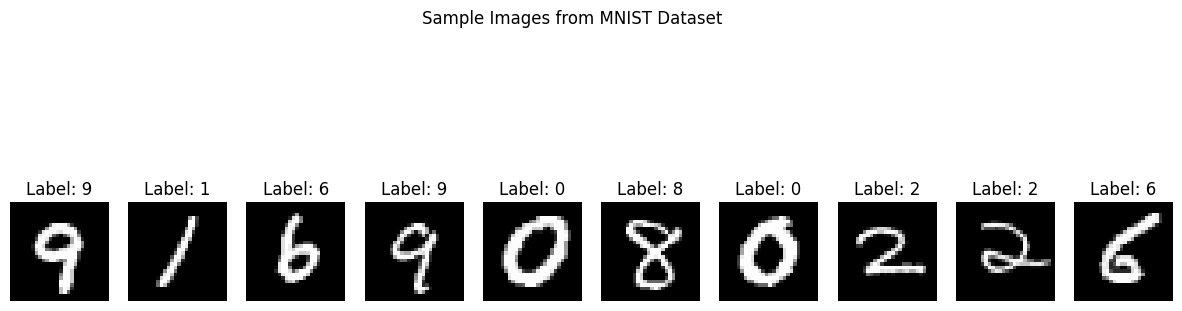

In [7]:

def show_images(images, labels, title):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, label) in enumerate(zip(images, labels)):
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

data_iter = iter(train_loader)
images, labels = next(data_iter)

show_images(images[:10], labels[:10], title="Sample Images from MNIST Dataset")


### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


# GAN Architecture Overview

## **Generator**
The **Generator** transforms a latent vector (random noise) into a generated image, such as a 28x28 pixel grayscale image (commonly used for datasets like MNIST).

### **Structure**
- **Input:** A latent vector of fixed size (`latent_dim`, e.g., 100).
- **Layers:**
  - Uses **transposed convolutions** (deconvolutions) to upsample the latent vector step by step.
  - Includes **batch normalization** and **ReLU activations** for stability and non-linearity.
- **Output:** Produces a 28x28 grayscale image with pixel values in the range [-1, 1] using a **Tanh activation**.

### **Parameters (defined in `config.yaml`):**
- `latent_dim`: Dimension of the input latent vector.
- `generator_channels`: Number of channels for each transposed convolutional layer.
- `generator_kernels`: Kernel sizes for the transposed convolutions.
- `generator_strides`: Strides used for upsampling.
- `generator_paddings`: Padding applied to maintain dimensions.
- `generator_output_paddings`: Controls the final output size for each layer.

---

## **Discriminator**
The **Discriminator** determines whether an input image is real (from the training dataset) or fake (generated by the Generator).

### **Structure**
- **Input:** An image (real or generated).
- **Layers:**
  - Uses **convolutions** to process the input image, progressively increasing the number of channels and downsampling the image.
  - Includes **LeakyReLU activations** to handle negative values and avoid dead neurons.
- **Output:** A single probability (0-1) from a fully connected layer with a **Sigmoid activation**, indicating whether the image is real or fake.

### **Parameters (defined in `config.yaml`):**
- `discriminator_channels`: Number of channels for each convolutional layer.
- `discriminator_kernels`: Kernel sizes for the convolutions.
- `discriminator_strides`: Strides used for downsampling.
- `discriminator_paddings`: Padding applied to the convolutional layers.

---

## **Model Parameters**
The architecture parameters for both models are stored in the `config.yaml` file:

### **Generator:**
- `latent_dim`
- `generator_channels`
- `generator_kernels`
- `generator_strides`
- `generator_paddings`
- `generator_output_paddings`

### **Discriminator:**
- `discriminator_channels`
- `discriminator_kernels`
- `discriminator_strides`
- `discriminator_paddings`

---

This setup uses **convolutions** and **transposed convolutions** to enable the Generator and Discriminator to iteratively compete and improve, ultimately resulting in realistic generated images.


In [8]:
config_file_path = 'config.yaml'
with open(config_file_path, 'r') as file:
    config_data = yaml.safe_load(file)

# Print the contents of the config file
print(config_data)

{'model_params': {'latent_dim': 100, 'generator_channels': [512, 256, 128], 'generator_kernels': [4, 4, 4, 4], 'generator_strides': [2, 2, 2, 2], 'generator_paddings': [1, 1, 1, 1], 'generator_output_paddings': [1, 1, 0, 0], 'discriminator_channels': [128, 256, 512], 'discriminator_kernels': [4, 4, 4, 4], 'discriminator_strides': [2, 2, 2, 2], 'discriminator_paddings': [1, 1, 1, 1]}}


In [9]:
import yaml
import torch.nn as nn

# Load configuration from YAML file
with open('/content/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

print(config)

# Generator class
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        layers = []
        input_channels = params['latent_dim']

        for out_channels, kernel, stride, padding, out_pad in zip(
            params['generator_channels'],
            params['generator_kernels'],
            params['generator_strides'],
            params['generator_paddings'],
            params['generator_output_paddings']):

            layers.extend([
                nn.ConvTranspose2d(input_channels, out_channels, kernel, stride, padding, out_pad),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(True)
            ])
            input_channels = out_channels

        layers.extend([
            nn.ConvTranspose2d(input_channels, 1, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        ])

        self.model = nn.Sequential(*layers)

    def forward(self, z):
        return self.model(z)

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()
        layers = []
        input_channels = 1

        for out_channels, kernel, stride, padding in zip(
            params['discriminator_channels'],
            params['discriminator_kernels'],
            params['discriminator_strides'],
            params['discriminator_paddings']):

            layers.extend([
                nn.Conv2d(input_channels, out_channels, kernel, stride, padding),
                nn.LeakyReLU(0.2, inplace=True)
            ])
            input_channels = out_channels

        layers.extend([
            nn.Flatten(),
            nn.Linear(params['discriminator_channels'][-1] * 3 * 3, 1),
            nn.Sigmoid()
        ])

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)



{'model_params': {'latent_dim': 100, 'generator_channels': [512, 256, 128], 'generator_kernels': [4, 4, 4, 4], 'generator_strides': [2, 2, 2, 2], 'generator_paddings': [1, 1, 1, 1], 'generator_output_paddings': [1, 1, 0, 0], 'discriminator_channels': [128, 256, 512], 'discriminator_kernels': [4, 4, 4, 4], 'discriminator_strides': [2, 2, 2, 2], 'discriminator_paddings': [1, 1, 1, 1]}}


In [10]:
# Instantiate models using parameters from config
generator = Generator(config['model_params'])
discriminator = Discriminator(config['model_params'])

print(generator)
print(discriminator)


Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (10): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Con

### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


# GAN Training Overview

## **1. Loss Function**
The **adversarial loss** uses **Binary Cross-Entropy (BCE)**:
- Measures how well the Discriminator classifies real vs. fake images.
- Guides the Generator to create more realistic images by "fooling" the Discriminator.

---

## **2. Optimizers**
Two separate **Adam optimizers** are used:
- **`optimizer_G`**: Optimizes the Generator.
- **`optimizer_D`**: Optimizes the Discriminator.

---

## **3. Training Loop**
The training process runs over multiple epochs, with each epoch processing batches of images:
- **Train the Generator**:
  - Generate fake images from random noise.
  - Aim: Fool the Discriminator into classifying fake images as real.
- **Train the Discriminator**:
  - Classify real images as real and fake images as fake.
- Both models are updated in each step for progressive improvement.

---

## **4. Sample Generation**
At regular intervals (`sample_interval`), the Generator creates and displays a grid of fake images:
- Visualizes the Generator's progress over time.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Binary Cross-Entropy loss
adversarial_loss = nn.BCELoss()

# Function to generate and display samples
def generate_samples(generator, latent_dim, device, epoch, num_samples=25):
    generator.eval()
    z = torch.randn(num_samples, latent_dim, 1, 1, device=device)
    gen_imgs = (generator(z).detach().cpu() + 1) / 2  # Rescale to [0, 1]

    grid = make_grid(gen_imgs, nrow=5, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title(f"Generated Samples at Epoch {epoch}")
    plt.axis('off')
    plt.show()

# GAN training function
def train_gan(generator, discriminator, train_loader, latent_dim, num_epochs, device, sample_interval):
    generator, discriminator = generator.to(device), discriminator.to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(1, num_epochs + 1):
        for i, (imgs, _) in enumerate(train_loader):
            batch_size = imgs.size(0)
            real_imgs, z = imgs.to(device), torch.randn(batch_size, latent_dim, 1, 1, device=device)
            valid, fake = torch.ones(batch_size, 1, device=device), torch.zeros(batch_size, 1, device=device)

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(generator(z)), valid)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(generator(z).detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Log progress every 50 batches
            if i % 50 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        # Generate samples every `sample_interval` epochs
        if epoch % sample_interval == 0:
            generate_samples(generator, latent_dim, device, epoch)


[Epoch 1/45] [Batch 0/469] [D loss: 0.7432] [G loss: 0.7021]
[Epoch 1/45] [Batch 50/469] [D loss: 0.4775] [G loss: 1.9017]
[Epoch 1/45] [Batch 100/469] [D loss: 0.3368] [G loss: 2.0948]
[Epoch 1/45] [Batch 150/469] [D loss: 0.3254] [G loss: 2.3494]
[Epoch 1/45] [Batch 200/469] [D loss: 0.3685] [G loss: 1.7500]
[Epoch 1/45] [Batch 250/469] [D loss: 0.5643] [G loss: 1.1300]
[Epoch 1/45] [Batch 300/469] [D loss: 0.6211] [G loss: 2.0231]
[Epoch 1/45] [Batch 350/469] [D loss: 0.4662] [G loss: 1.4398]
[Epoch 1/45] [Batch 400/469] [D loss: 0.4303] [G loss: 1.4573]
[Epoch 1/45] [Batch 450/469] [D loss: 0.4972] [G loss: 2.8478]
[Epoch 2/45] [Batch 0/469] [D loss: 0.8755] [G loss: 3.6662]
[Epoch 2/45] [Batch 50/469] [D loss: 0.5462] [G loss: 1.1329]
[Epoch 2/45] [Batch 100/469] [D loss: 0.5255] [G loss: 1.7942]
[Epoch 2/45] [Batch 150/469] [D loss: 0.5416] [G loss: 1.5061]
[Epoch 2/45] [Batch 200/469] [D loss: 0.5877] [G loss: 1.0192]
[Epoch 2/45] [Batch 250/469] [D loss: 0.5888] [G loss: 0.8458

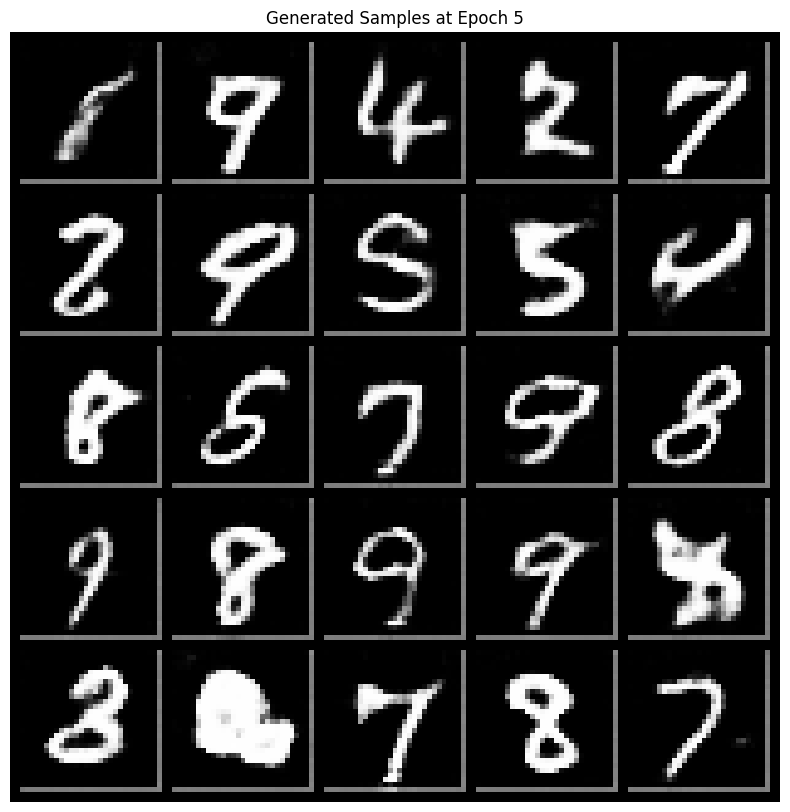

[Epoch 6/45] [Batch 0/469] [D loss: 0.5445] [G loss: 1.1660]
[Epoch 6/45] [Batch 50/469] [D loss: 0.5961] [G loss: 1.0399]
[Epoch 6/45] [Batch 100/469] [D loss: 0.5678] [G loss: 1.0083]
[Epoch 6/45] [Batch 150/469] [D loss: 0.6456] [G loss: 0.9959]
[Epoch 6/45] [Batch 200/469] [D loss: 0.6434] [G loss: 1.1450]
[Epoch 6/45] [Batch 250/469] [D loss: 0.6003] [G loss: 1.3146]
[Epoch 6/45] [Batch 300/469] [D loss: 0.6858] [G loss: 0.9844]
[Epoch 6/45] [Batch 350/469] [D loss: 0.6519] [G loss: 1.0407]
[Epoch 6/45] [Batch 400/469] [D loss: 0.7374] [G loss: 1.0158]
[Epoch 6/45] [Batch 450/469] [D loss: 0.5887] [G loss: 1.3172]
[Epoch 7/45] [Batch 0/469] [D loss: 0.6550] [G loss: 0.8856]
[Epoch 7/45] [Batch 50/469] [D loss: 0.6312] [G loss: 0.8417]
[Epoch 7/45] [Batch 100/469] [D loss: 0.6038] [G loss: 1.0217]
[Epoch 7/45] [Batch 150/469] [D loss: 0.6003] [G loss: 1.1828]
[Epoch 7/45] [Batch 200/469] [D loss: 0.6365] [G loss: 0.8849]
[Epoch 7/45] [Batch 250/469] [D loss: 0.6545] [G loss: 0.8418

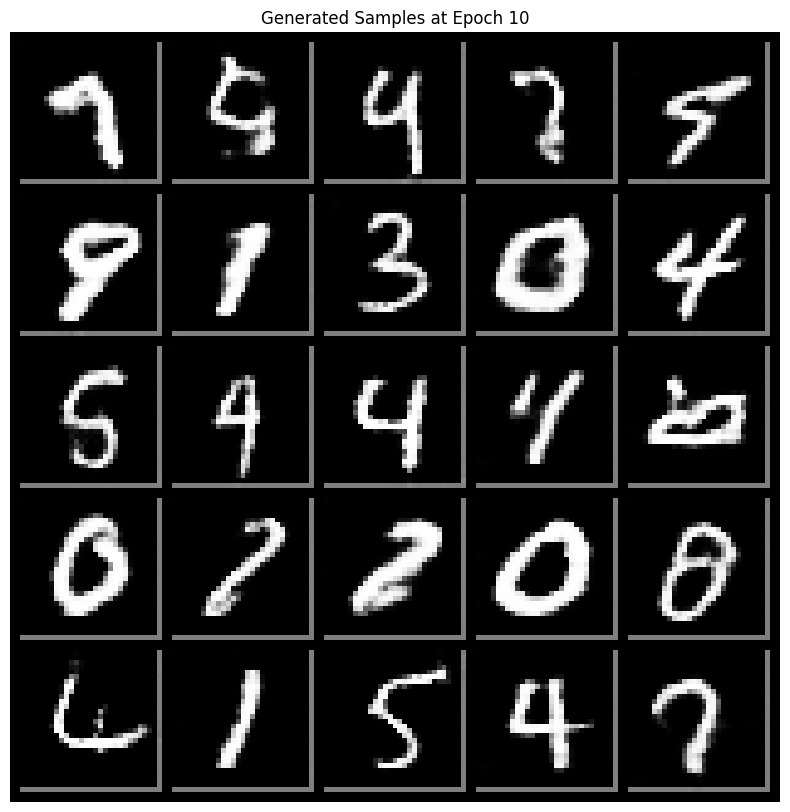

[Epoch 11/45] [Batch 0/469] [D loss: 0.6866] [G loss: 1.2583]
[Epoch 11/45] [Batch 50/469] [D loss: 0.6482] [G loss: 0.7855]
[Epoch 11/45] [Batch 100/469] [D loss: 0.6572] [G loss: 0.8213]
[Epoch 11/45] [Batch 150/469] [D loss: 0.6303] [G loss: 1.0516]
[Epoch 11/45] [Batch 200/469] [D loss: 0.6858] [G loss: 1.1604]
[Epoch 11/45] [Batch 250/469] [D loss: 0.6494] [G loss: 0.9964]
[Epoch 11/45] [Batch 300/469] [D loss: 0.6557] [G loss: 1.1412]
[Epoch 11/45] [Batch 350/469] [D loss: 0.6486] [G loss: 1.1449]
[Epoch 11/45] [Batch 400/469] [D loss: 0.6548] [G loss: 1.1392]
[Epoch 11/45] [Batch 450/469] [D loss: 0.6493] [G loss: 1.0596]
[Epoch 12/45] [Batch 0/469] [D loss: 0.6572] [G loss: 0.9454]
[Epoch 12/45] [Batch 50/469] [D loss: 0.6541] [G loss: 0.9896]
[Epoch 12/45] [Batch 100/469] [D loss: 0.6568] [G loss: 0.8337]
[Epoch 12/45] [Batch 150/469] [D loss: 0.6782] [G loss: 0.8054]
[Epoch 12/45] [Batch 200/469] [D loss: 0.6843] [G loss: 0.5878]
[Epoch 12/45] [Batch 250/469] [D loss: 0.6611]

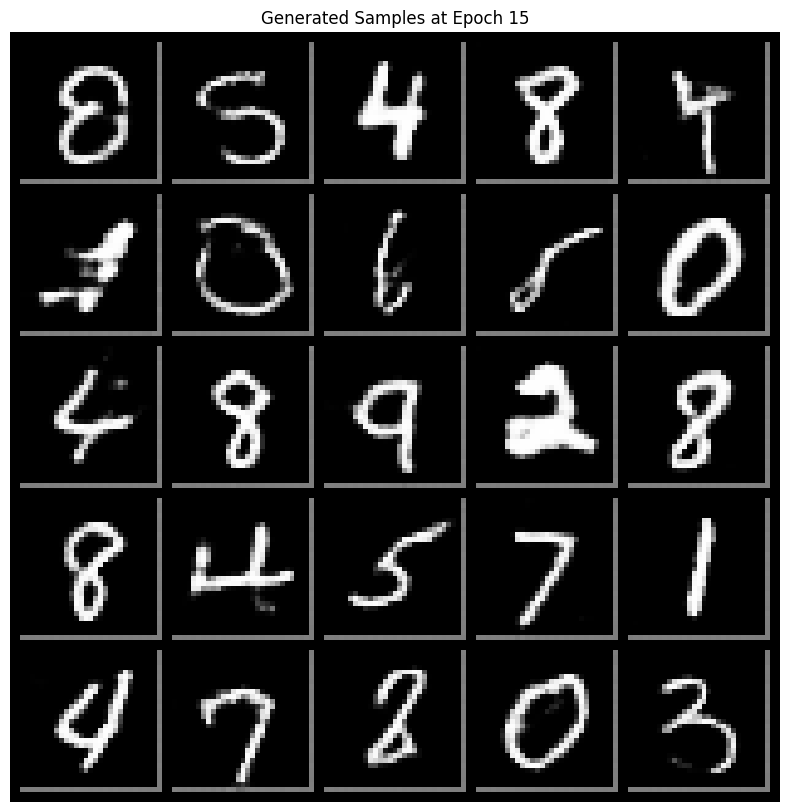

[Epoch 16/45] [Batch 0/469] [D loss: 0.7033] [G loss: 0.7270]
[Epoch 16/45] [Batch 50/469] [D loss: 0.6675] [G loss: 0.7674]
[Epoch 16/45] [Batch 100/469] [D loss: 0.6716] [G loss: 1.1264]
[Epoch 16/45] [Batch 150/469] [D loss: 0.6446] [G loss: 0.7530]
[Epoch 16/45] [Batch 200/469] [D loss: 0.6664] [G loss: 0.8358]
[Epoch 16/45] [Batch 250/469] [D loss: 0.7015] [G loss: 0.5982]
[Epoch 16/45] [Batch 300/469] [D loss: 0.6471] [G loss: 0.9545]
[Epoch 16/45] [Batch 350/469] [D loss: 0.6878] [G loss: 0.7208]
[Epoch 16/45] [Batch 400/469] [D loss: 0.6863] [G loss: 0.8033]
[Epoch 16/45] [Batch 450/469] [D loss: 0.6880] [G loss: 1.0022]
[Epoch 17/45] [Batch 0/469] [D loss: 0.6626] [G loss: 0.8386]
[Epoch 17/45] [Batch 50/469] [D loss: 0.6611] [G loss: 1.1000]
[Epoch 17/45] [Batch 100/469] [D loss: 0.6590] [G loss: 0.9090]
[Epoch 17/45] [Batch 150/469] [D loss: 0.7157] [G loss: 0.6108]
[Epoch 17/45] [Batch 200/469] [D loss: 0.6602] [G loss: 0.9637]
[Epoch 17/45] [Batch 250/469] [D loss: 0.6783]

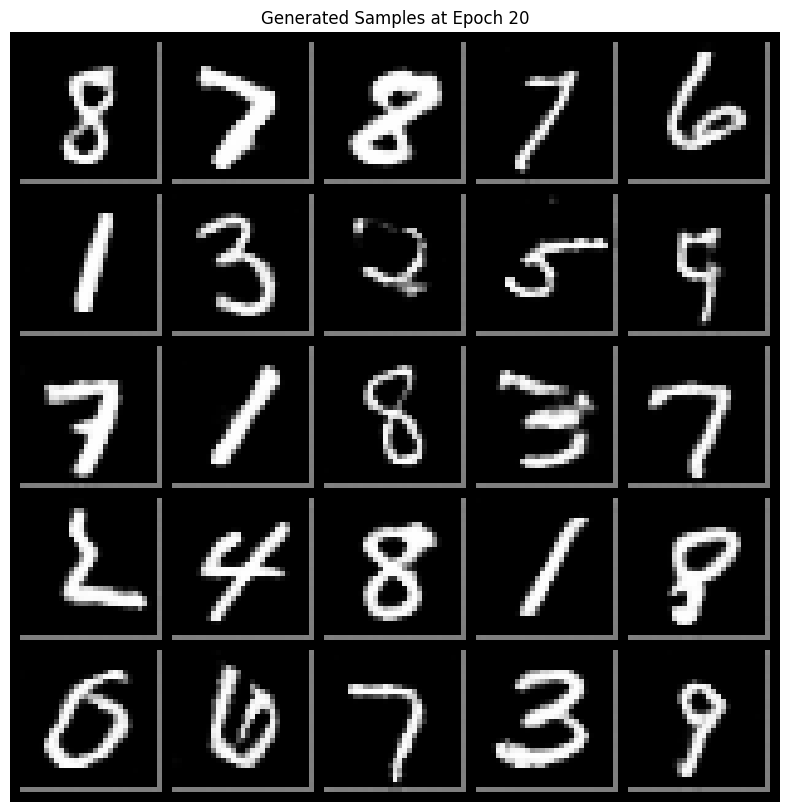

[Epoch 21/45] [Batch 0/469] [D loss: 0.6591] [G loss: 1.0786]
[Epoch 21/45] [Batch 50/469] [D loss: 0.6384] [G loss: 1.0039]
[Epoch 21/45] [Batch 100/469] [D loss: 0.6274] [G loss: 0.9592]
[Epoch 21/45] [Batch 150/469] [D loss: 0.6599] [G loss: 1.0744]
[Epoch 21/45] [Batch 200/469] [D loss: 0.7151] [G loss: 1.1311]
[Epoch 21/45] [Batch 250/469] [D loss: 0.7049] [G loss: 0.8420]
[Epoch 21/45] [Batch 300/469] [D loss: 0.7030] [G loss: 0.6382]
[Epoch 21/45] [Batch 350/469] [D loss: 0.6904] [G loss: 0.9011]
[Epoch 21/45] [Batch 400/469] [D loss: 0.6790] [G loss: 0.9520]
[Epoch 21/45] [Batch 450/469] [D loss: 0.6516] [G loss: 0.8957]
[Epoch 22/45] [Batch 0/469] [D loss: 0.6584] [G loss: 0.9804]
[Epoch 22/45] [Batch 50/469] [D loss: 0.6326] [G loss: 0.9784]
[Epoch 22/45] [Batch 100/469] [D loss: 0.6614] [G loss: 0.8365]
[Epoch 22/45] [Batch 150/469] [D loss: 0.6729] [G loss: 0.8778]
[Epoch 22/45] [Batch 200/469] [D loss: 0.6606] [G loss: 0.9117]
[Epoch 22/45] [Batch 250/469] [D loss: 0.6481]

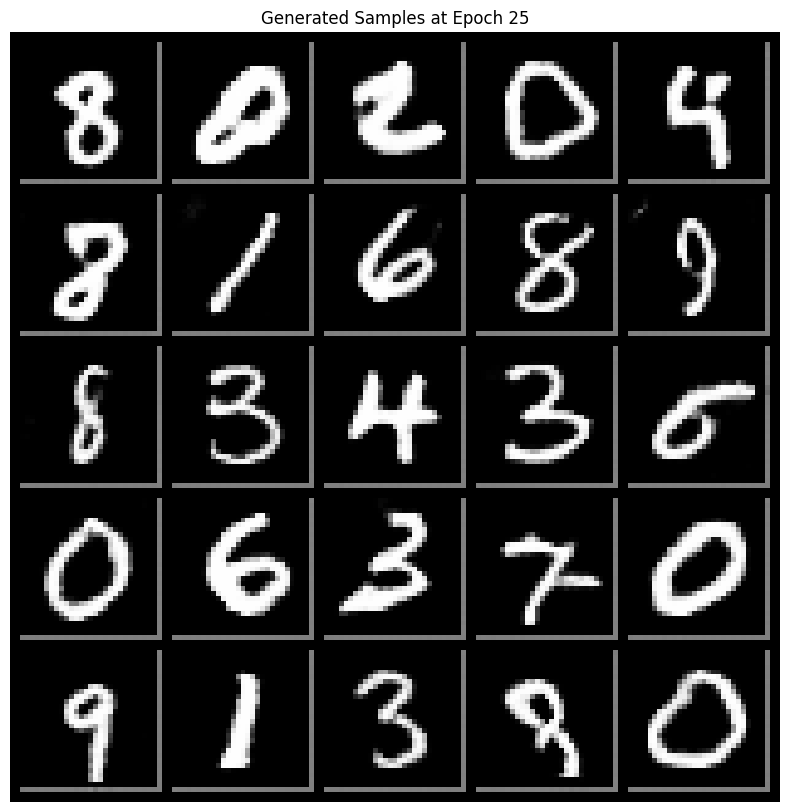

[Epoch 26/45] [Batch 0/469] [D loss: 0.6589] [G loss: 0.8917]
[Epoch 26/45] [Batch 50/469] [D loss: 0.6399] [G loss: 1.0490]
[Epoch 26/45] [Batch 100/469] [D loss: 0.6529] [G loss: 0.8356]
[Epoch 26/45] [Batch 150/469] [D loss: 0.6412] [G loss: 1.2232]
[Epoch 26/45] [Batch 200/469] [D loss: 0.6383] [G loss: 0.8969]
[Epoch 26/45] [Batch 250/469] [D loss: 0.6485] [G loss: 0.9189]
[Epoch 26/45] [Batch 300/469] [D loss: 0.6561] [G loss: 1.1597]
[Epoch 26/45] [Batch 350/469] [D loss: 0.6401] [G loss: 0.9622]
[Epoch 26/45] [Batch 400/469] [D loss: 0.6386] [G loss: 0.9818]
[Epoch 26/45] [Batch 450/469] [D loss: 0.6317] [G loss: 1.0992]
[Epoch 27/45] [Batch 0/469] [D loss: 0.6229] [G loss: 1.1876]
[Epoch 27/45] [Batch 50/469] [D loss: 0.6658] [G loss: 1.0799]
[Epoch 27/45] [Batch 100/469] [D loss: 0.6669] [G loss: 0.8062]
[Epoch 27/45] [Batch 150/469] [D loss: 0.6556] [G loss: 0.9112]
[Epoch 27/45] [Batch 200/469] [D loss: 0.6375] [G loss: 0.8257]
[Epoch 27/45] [Batch 250/469] [D loss: 0.6641]

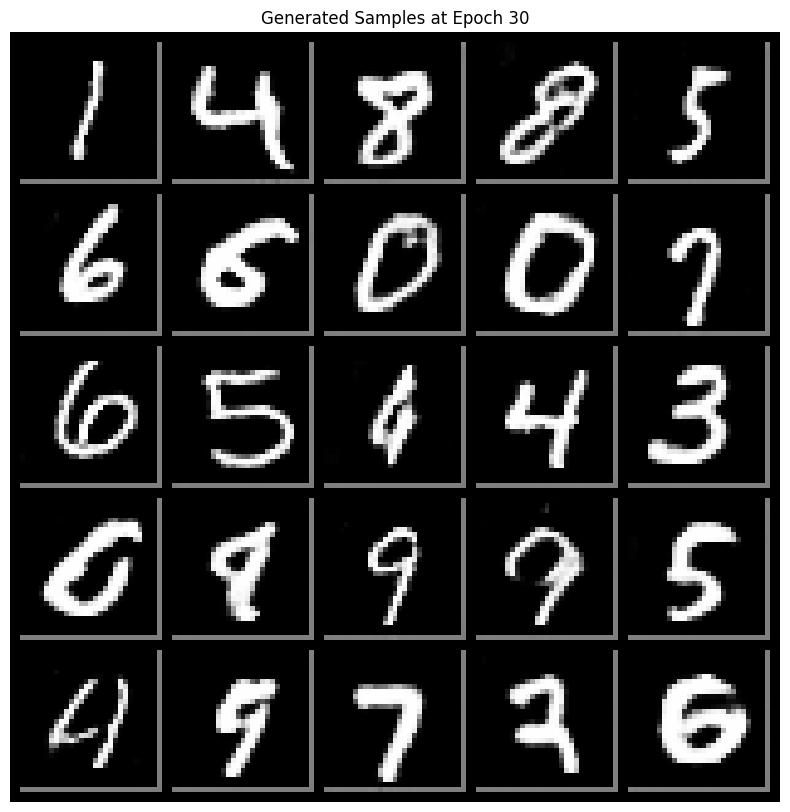

[Epoch 31/45] [Batch 0/469] [D loss: 0.6416] [G loss: 1.2066]
[Epoch 31/45] [Batch 50/469] [D loss: 0.6594] [G loss: 0.9665]
[Epoch 31/45] [Batch 100/469] [D loss: 0.6325] [G loss: 0.9174]
[Epoch 31/45] [Batch 150/469] [D loss: 0.6362] [G loss: 1.0089]
[Epoch 31/45] [Batch 200/469] [D loss: 0.6457] [G loss: 0.9290]
[Epoch 31/45] [Batch 250/469] [D loss: 0.6709] [G loss: 0.7655]
[Epoch 31/45] [Batch 300/469] [D loss: 0.6614] [G loss: 1.0977]
[Epoch 31/45] [Batch 350/469] [D loss: 0.6902] [G loss: 0.9397]
[Epoch 31/45] [Batch 400/469] [D loss: 0.6521] [G loss: 1.1192]
[Epoch 31/45] [Batch 450/469] [D loss: 0.6452] [G loss: 0.8141]
[Epoch 32/45] [Batch 0/469] [D loss: 0.6249] [G loss: 0.9455]
[Epoch 32/45] [Batch 50/469] [D loss: 0.6563] [G loss: 0.8463]
[Epoch 32/45] [Batch 100/469] [D loss: 0.6283] [G loss: 0.9622]
[Epoch 32/45] [Batch 150/469] [D loss: 0.6355] [G loss: 1.1086]
[Epoch 32/45] [Batch 200/469] [D loss: 0.6327] [G loss: 0.9554]
[Epoch 32/45] [Batch 250/469] [D loss: 0.6394]

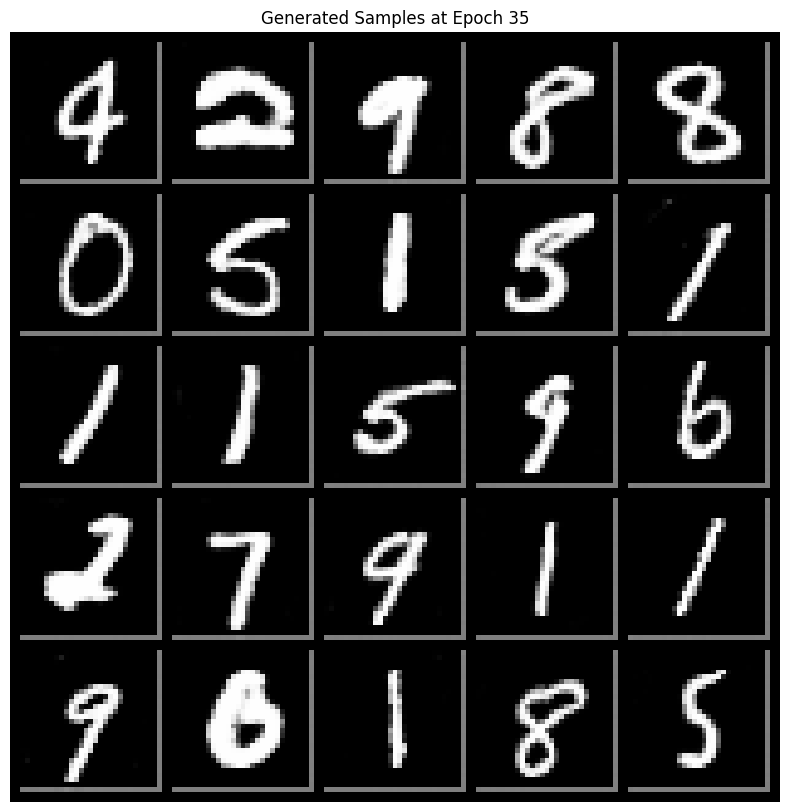

[Epoch 36/45] [Batch 0/469] [D loss: 0.6518] [G loss: 1.1762]
[Epoch 36/45] [Batch 50/469] [D loss: 0.6063] [G loss: 1.0096]
[Epoch 36/45] [Batch 100/469] [D loss: 0.6387] [G loss: 0.8294]
[Epoch 36/45] [Batch 150/469] [D loss: 0.6166] [G loss: 0.9146]
[Epoch 36/45] [Batch 200/469] [D loss: 0.6444] [G loss: 1.1889]
[Epoch 36/45] [Batch 250/469] [D loss: 0.6407] [G loss: 1.1756]
[Epoch 36/45] [Batch 300/469] [D loss: 0.6308] [G loss: 1.2063]
[Epoch 36/45] [Batch 350/469] [D loss: 0.6344] [G loss: 0.9929]
[Epoch 36/45] [Batch 400/469] [D loss: 0.6455] [G loss: 1.0731]
[Epoch 36/45] [Batch 450/469] [D loss: 0.6300] [G loss: 1.0651]
[Epoch 37/45] [Batch 0/469] [D loss: 0.6589] [G loss: 0.9916]
[Epoch 37/45] [Batch 50/469] [D loss: 0.6019] [G loss: 1.0003]
[Epoch 37/45] [Batch 100/469] [D loss: 0.6505] [G loss: 0.8073]
[Epoch 37/45] [Batch 150/469] [D loss: 0.6437] [G loss: 1.2809]
[Epoch 37/45] [Batch 200/469] [D loss: 0.6256] [G loss: 0.8482]
[Epoch 37/45] [Batch 250/469] [D loss: 0.6506]

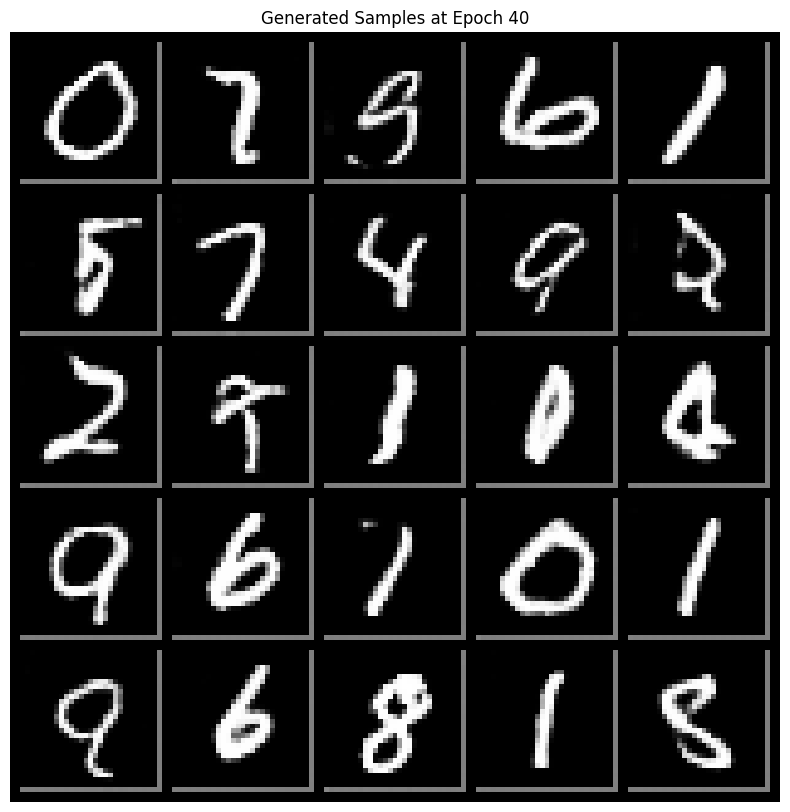

[Epoch 41/45] [Batch 0/469] [D loss: 0.6212] [G loss: 1.0425]
[Epoch 41/45] [Batch 50/469] [D loss: 0.6529] [G loss: 0.8165]
[Epoch 41/45] [Batch 100/469] [D loss: 0.6014] [G loss: 0.9214]
[Epoch 41/45] [Batch 150/469] [D loss: 0.6100] [G loss: 1.0717]
[Epoch 41/45] [Batch 200/469] [D loss: 0.6015] [G loss: 1.2455]
[Epoch 41/45] [Batch 250/469] [D loss: 0.6137] [G loss: 0.9895]
[Epoch 41/45] [Batch 300/469] [D loss: 0.5931] [G loss: 1.1370]
[Epoch 41/45] [Batch 350/469] [D loss: 0.6147] [G loss: 1.2835]
[Epoch 41/45] [Batch 400/469] [D loss: 0.6358] [G loss: 0.8437]
[Epoch 41/45] [Batch 450/469] [D loss: 0.6447] [G loss: 0.8242]
[Epoch 42/45] [Batch 0/469] [D loss: 0.6364] [G loss: 1.1654]
[Epoch 42/45] [Batch 50/469] [D loss: 0.6215] [G loss: 0.8903]
[Epoch 42/45] [Batch 100/469] [D loss: 0.6066] [G loss: 1.0419]
[Epoch 42/45] [Batch 150/469] [D loss: 0.6332] [G loss: 0.9502]
[Epoch 42/45] [Batch 200/469] [D loss: 0.6261] [G loss: 0.9240]
[Epoch 42/45] [Batch 250/469] [D loss: 0.6156]

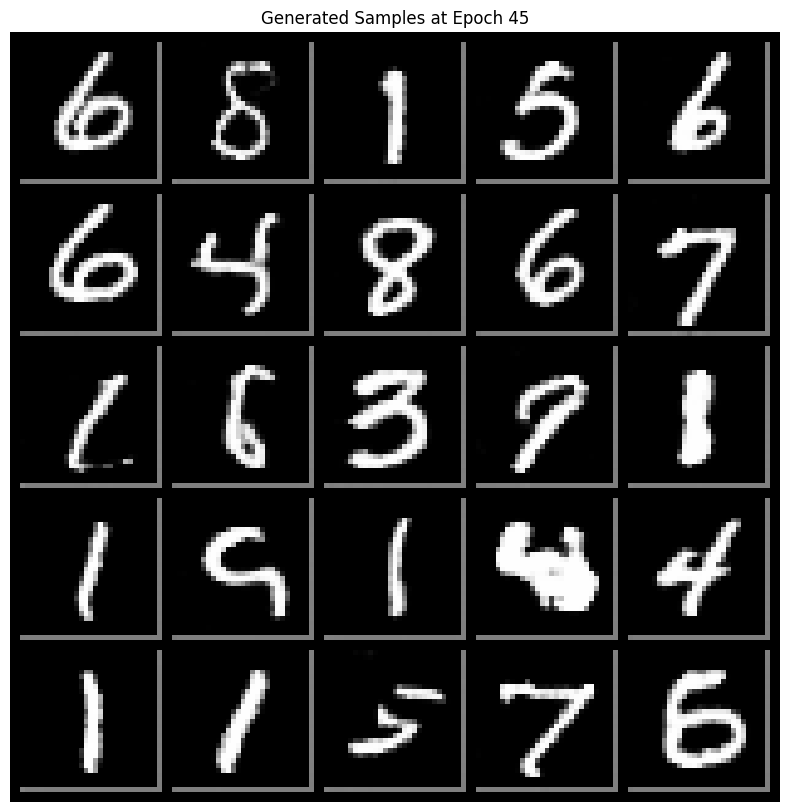

In [12]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 45
latent_dim = config_data['model_params']['latent_dim']
sample_interval = 5

# Train the GAN
train_gan(generator, discriminator, train_loader, latent_dim, num_epochs, device, sample_interval)


**Save Model**

In [26]:
# Save the generator state and its configuration
save_path = "generator.pth"
torch.save({
    'model_state_dict': generator.state_dict(),
    'config': {
        'latent_dim': latent_dim,
        'generator_channels': generator_channels,
        'generator_kernels': generator_kernels,
        'generator_strides': generator_strides,
        'generator_paddings': generator_paddings,
        'generator_output_paddings': generator_output_paddings
    }
}, save_path)

print(f"Generator saved to {save_path}")


Generator saved to generator.pth


**Load Model**

In [27]:
# Load the saved generator state and configuration
checkpoint = torch.load("generator.pth", map_location="cpu")  # Use map_location for safety in case of device mismatch

# Extract the configuration
config = checkpoint['config']

# Recreate the Generator model using the loaded configuration
generator = Generator(config)

# Load the saved weights
generator.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode (important for inference)
generator.eval()

print("Generator reloaded successfully")


Generator reloaded successfully


<ipython-input-27-270a4dd6c2b5>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("generator.pth", map_location="cpu")  # Use map_location for safety 

### Part 4: Plot a grid of 100 generated samples.

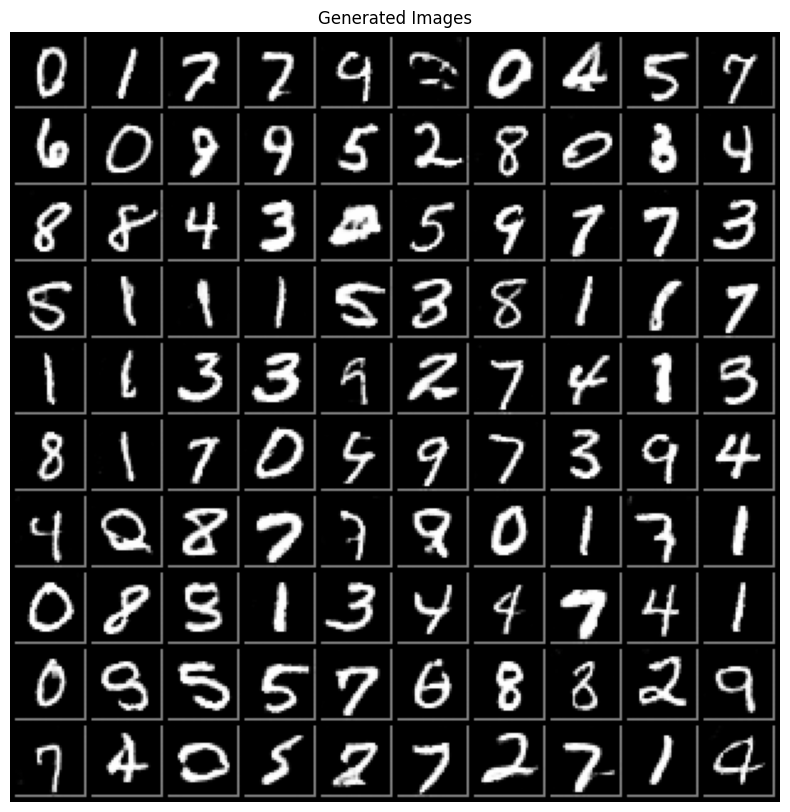

In [30]:
import matplotlib.pyplot as plt
import torchvision

def plot_generated_images(generator, latent_dim, device, num_images=100, grid_size=(10, 10)):
    """
    Generate and plot images using the generator model.

    Args:
        generator (nn.Module): The trained generator model.
        latent_dim (int): Dimensionality of the latent vector.
        device (torch.device): The device to run the generator on.
        num_images (int): Number of images to generate and plot.
        grid_size (tuple): Grid size for arranging images (rows, cols).
    """
    # Move the generator to the specified device
    generator.to(device)
    generator.eval()

    # Generate random latent vectors
    z = torch.randn(num_images, latent_dim, 1, 1, device=device)

    # Generate fake images from the latent vectors
    with torch.no_grad():
        fake_images = generator(z)

    # Rescale the images to [0, 1] for plotting
    fake_images = (fake_images + 1) / 2  # Tanh outputs values in [-1, 1]

    # Create a grid of images
    grid = torchvision.utils.make_grid(fake_images, nrow=grid_size[1], normalize=True, value_range=(0, 1))

    # Plot the images
    plt.figure(figsize=(grid_size[1], grid_size[0]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    plt.axis('off')
    plt.title("Generated Images")
    plt.show()

# Example usage
plot_generated_images(generator, latent_dim=config['latent_dim'], device=device, num_images=100, grid_size=(10, 10))


### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


# Image Matching Using Latent Vector Optimization

## **1. Random Initialization**
- A latent vector \( z \) is randomly initialized from a normal distribution.
- This vector serves as the starting point for the optimization process, acting as the seed for generating images.

---

## **2. Freeze the Generator**
- The **Generator** is set to evaluation mode using `generator.eval()`.
  - This ensures that the Generator's parameters remain **unchanged** during the process.
- Only the latent vector \( z \) is updated during optimization, keeping the model fixed.

---

## **3. Loss Function**
- The **Mean Squared Error (MSE)** is used as the loss function:
  - Compares the generated image with the real image pixel by pixel.
  - Provides a measure of how closely the generated image resembles the real image.
- Lower MSE indicates better matching between the two images.

---

## **4. Optimization Process**
- The latent vector \( z \) is iteratively updated to minimize the **MSE loss**:
  - During each optimization step, \( z \) is used as input to the Generator to produce a new image.
  - The new image is evaluated against the real image, and \( z \) is adjusted accordingly.
  - This iterative process refines \( z \) to generate images that closely approximate the target.

---

## **5. Generated Image Matching**
- After a specified number of optimization steps (`num_steps`), the process outputs:
  1. The **optimized latent vector \( z \)**, representing the best seed for generating the desired image.
  2. The **generated image**, which closely matches the real image, thanks to the optimized \( z \).



Inverting image 1/10
Step [0/200], Loss: 0.5858260989189148


<ipython-input-34-82720171e7a1>:45: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(generated_image_resized, real_image)


Step [100/200], Loss: 0.36845624446868896
Inverting image 2/10
Step [0/200], Loss: 0.5396561026573181
Step [100/200], Loss: 0.21260078251361847
Inverting image 3/10
Step [0/200], Loss: 0.3369973599910736
Step [100/200], Loss: 0.11976706981658936
Inverting image 4/10
Step [0/200], Loss: 0.45385342836380005
Step [100/200], Loss: 0.35167425870895386
Inverting image 5/10
Step [0/200], Loss: 0.5129208564758301
Step [100/200], Loss: 0.19318340718746185
Inverting image 6/10
Step [0/200], Loss: 0.700806736946106
Step [100/200], Loss: 0.2880304753780365
Inverting image 7/10
Step [0/200], Loss: 0.47226956486701965
Step [100/200], Loss: 0.13496831059455872
Inverting image 8/10
Step [0/200], Loss: 0.6245991587638855
Step [100/200], Loss: 0.12068096548318863
Inverting image 9/10
Step [0/200], Loss: 0.5846908688545227
Step [100/200], Loss: 0.23843932151794434
Inverting image 10/10
Step [0/200], Loss: 0.43384087085723877
Step [100/200], Loss: 0.21922515332698822


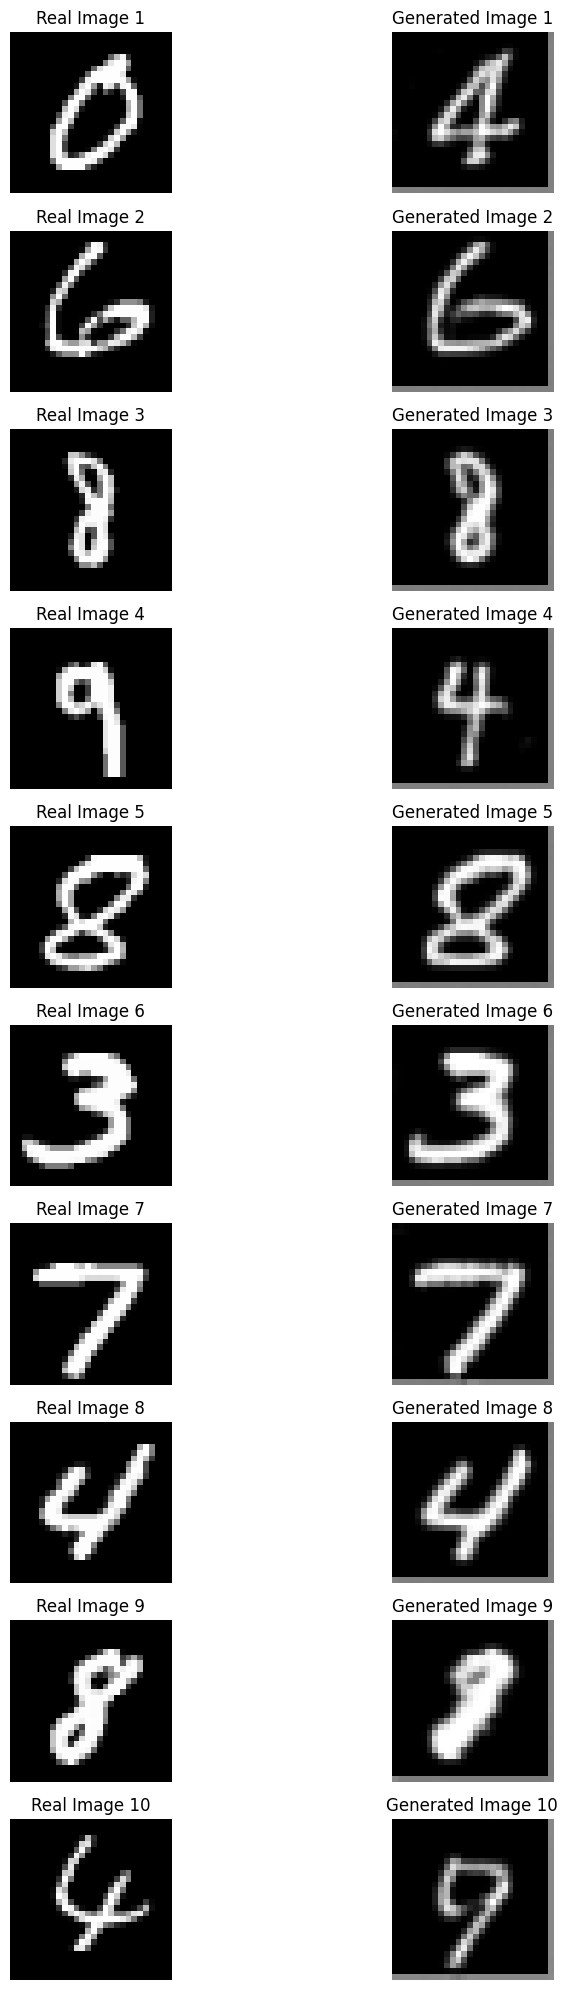

In [34]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

def invert_to_latent_vector(generator, real_image, latent_dim, device, num_steps=200, lr=0.01):
    """
    Inverts a real image to its corresponding latent vector by optimizing the latent vector.

    Args:
        generator (torch.nn.Module): The generator model.
        real_image (torch.Tensor or np.ndarray): The real image to be inverted.
        latent_dim (int): The dimension of the latent vector.
        device (torch.device): The device (CPU or CUDA).
        num_steps (int): The number of optimization steps.
        lr (float): The learning rate for optimizing the latent vector.

    Returns:
        torch.Tensor: The inverted latent vector (z).
        torch.Tensor: The generated image corresponding to the inverted latent vector.
    """
    # Set generator to evaluation mode (not trainable)
    generator.eval()

    # Initialize the latent vector (z) as a random tensor
    z = torch.randn(1, latent_dim, 1, 1, device=device, requires_grad=True)

    # Set the optimizer for the latent vector (z)
    optimizer = optim.Adam([z], lr=lr, betas=(0.5, 0.999))

    # Normalize the real image to the range [-1, 1]
    if isinstance(real_image, np.ndarray):
        real_image = torch.tensor(real_image, dtype=torch.float32)

    real_image = real_image.to(device)

    for step in range(num_steps):
        # Generate an image from the current latent vector
        generated_image = generator(z)

        # Resize the generated image to match the real image dimensions (28x28)
        generated_image_resized = F.interpolate(generated_image, size=(28, 28), mode='bilinear', align_corners=False)

        # Calculate the MSE loss between the resized generated image and the real image
        loss = F.mse_loss(generated_image_resized, real_image)

        # Optimize the latent vector (z)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss for monitoring
        if step % 100 == 0:
            print(f"Step [{step}/{num_steps}], Loss: {loss.item()}")

    # After optimization, return the latent vector and the resized generated image
    return z, generated_image_resized


def plot_latent_inversion(real_images, generated_images, n):
    """
    Plots real images alongside their corresponding generated images after GAN inversion.

    Args:
        real_images (list of torch.Tensor): List of real images.
        generated_images (list of torch.Tensor): List of generated images after inversion.
        n (int): The number of images to plot.
    """
    plt.figure(figsize=(10, 2 * n))

    for i in range(n):
        # Plot real image
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(real_images[i].cpu().detach().squeeze(), cmap='gray')  # Detach and move to CPU for plotting
        plt.title(f"Real Image {i+1}")
        plt.axis('off')

        # Plot generated image
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(generated_images[i].cpu().detach().squeeze(), cmap='gray')  # Detach and move to CPU for plotting
        plt.title(f"Generated Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
n = 10  # Number of images to process and plot
real_images = [next(iter(train_loader))[0][i] for i in range(n)]  # Assuming you have a DataLoader called train_loader

generated_images = []
for i, real_image in enumerate(real_images):
    print(f"Inverting image {i + 1}/{n}")
    z, generated_image = invert_to_latent_vector(generator, real_image, latent_dim=config['latent_dim'], device=device)
    generated_images.append(generated_image[0])  # Append single image from batch

# Plot the real images and their corresponding generated images
plot_latent_inversion(real_images, generated_images, n)


### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

<ipython-input-34-82720171e7a1>:45: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(generated_image_resized, real_image)


Step [0/200], Loss: 0.4510195851325989
Step [100/200], Loss: 0.3907527029514313
Step [0/200], Loss: 0.5054484605789185
Step [100/200], Loss: 0.16758061945438385
Step [0/200], Loss: 0.5285845398902893
Step [100/200], Loss: 0.119692862033844
Step [0/200], Loss: 0.5023236870765686
Step [100/200], Loss: 0.2551238238811493


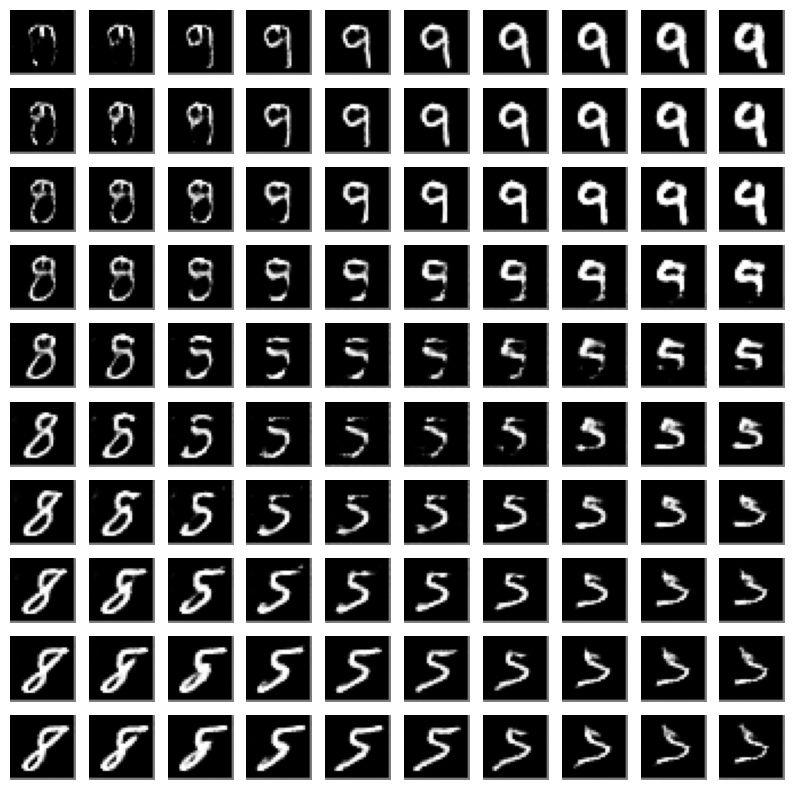

In [35]:
def interpolate_latent_space(generator, latent_vectors, grid_size=10, device=device):
    # Create a grid of latent vectors by interpolating between the four corner vectors
    z1, z2, z3, z4 = latent_vectors

    # Create a 10x10 grid for interpolation
    grid = np.zeros((grid_size, grid_size, 100, 1, 1))  # shape will be (10, 10, latent_dim, 1, 1)

    for i in range(grid_size):
        for j in range(grid_size):
            # Interpolation weights between z1-z2, z2-z4, z4-z3, z3-z1
            w1 = i / (grid_size - 1)  # Weight for the interpolation between z1 and z2
            w2 = j / (grid_size - 1)  # Weight for the interpolation between z2 and z4

            # Interpolate between z1, z2, z3, z4 along the sides of the square
            latent_vector = (1 - w1) * (1 - w2) * z1 + w1 * (1 - w2) * z2 + w1 * w2 * z4 + (1 - w1) * w2 * z3
            grid[i, j] = latent_vector.cpu().detach().numpy()

    # Generate the images using the interpolated latent vectors
    generated_images = []
    for i in range(grid_size):
        row_images = []
        for j in range(grid_size):
            latent_vector = torch.tensor(grid[i, j], dtype=torch.float32, device=device).unsqueeze(0)
            generated_image = generator(latent_vector)  # Generate image from latent vector
            row_images.append(generated_image.squeeze().cpu().detach().numpy())
        generated_images.append(row_images)

    return np.array(generated_images)

def plot_generated_images(images, grid_size=10):
    # Plot the 10x10 grid of generated images
    plt.figure(figsize=(10, 10))
    for i in range(grid_size):
        for j in range(grid_size):
            plt.subplot(grid_size, grid_size, i * grid_size + j + 1)
            plt.imshow(images[i, j], cmap='gray')
            plt.axis('off')
    plt.show()

real_images = [next(iter(train_loader))[0][0] for _ in range(4)]

# Run GAN inversion to find the latent vectors for these real images
latent_vectors = []
for real_image in real_images:
    z, _ = invert_to_latent_vector(generator, real_image, latent_dim=100, device=device)
    latent_vectors.append(z)

# Interpolate the latent space using the selected vectors
generated_images = interpolate_latent_space(generator, latent_vectors, grid_size=10, device=device)

# Plot the generated images in a 10x10 grid
plot_generated_images(generated_images, grid_size=10)


### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.


# Dataset Sampling and Latent Space Analysis for Image Attributes

## **1. Sampling and Analyzing the Dataset**
This step identifies "thin" and "thick" images for each class (e.g., digits 0-9 in the MNIST dataset).

### **Key Functions**
- **`sample_images_by_label`**:
  - Groups images by label (e.g., all '3's together).
  - Samples a fixed number of images (`num_samples`) for each class.
  
- **`compute_pixel_sums`**:
  - Calculates the total sum of pixel values for each image.
  - Thin digits have lower pixel sums, while thick digits have higher sums.
  
- **`select_extremes`**:
  - Sorts images based on pixel sums.
  - Selects the "thinnest" (lowest sums) and "thickest" (highest sums) images.

- **`generate_thin_thick_images`**:
  - Samples the thinnest and thickest images for each class.
  - Outputs:
    - `thin_images`: List of the thinnest images across classes.
    - `thick_images`: List of the thickest images across classes.

---

## **2. Identifying Latent Space Direction**
The goal is to find a direction in the GAN's latent space corresponding to the "thickness" attribute.

### **Key Functions**
- **`identify_direction`**:
  1. **Invert Images to Latent Space**:
     - Maps thin and thick images to their latent representations using `invert_to_latent_vector`.
  2. **Compute Pairwise Differences**:
     - Calculates the difference between latent vectors of thin-thick pairs for the same class.
  3. **Average the Differences**:
     - Averages these differences to compute a **direction vector** in the latent space.
     - This direction vector represents the transformation from "thin" to "thick."

---

## **3. Modifying Images Using the Direction Vector**
With the direction vector identified, the GAN can modify image attributes by manipulating latent vectors.



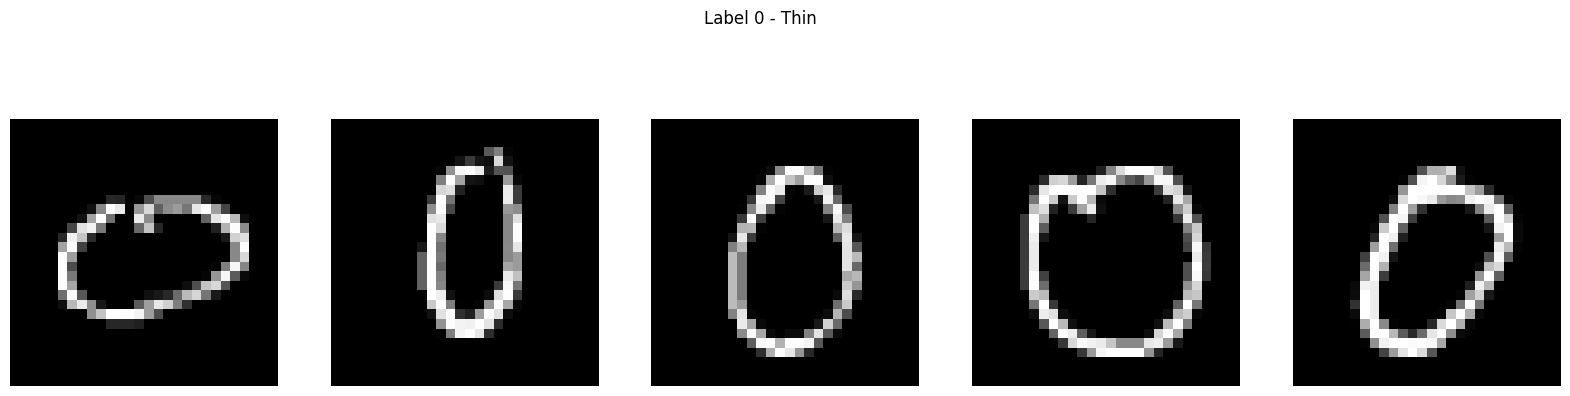

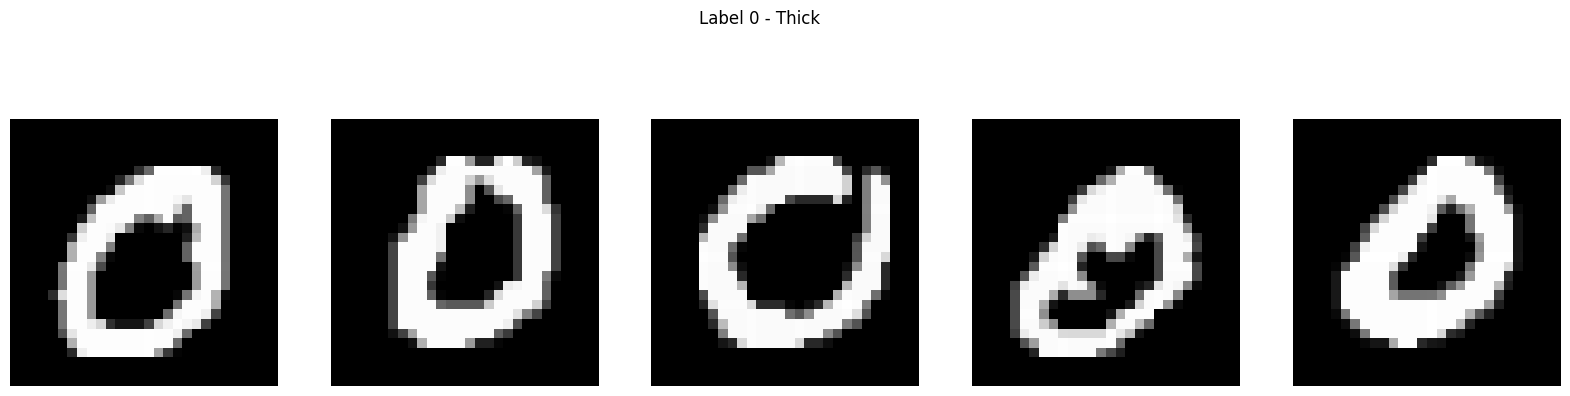

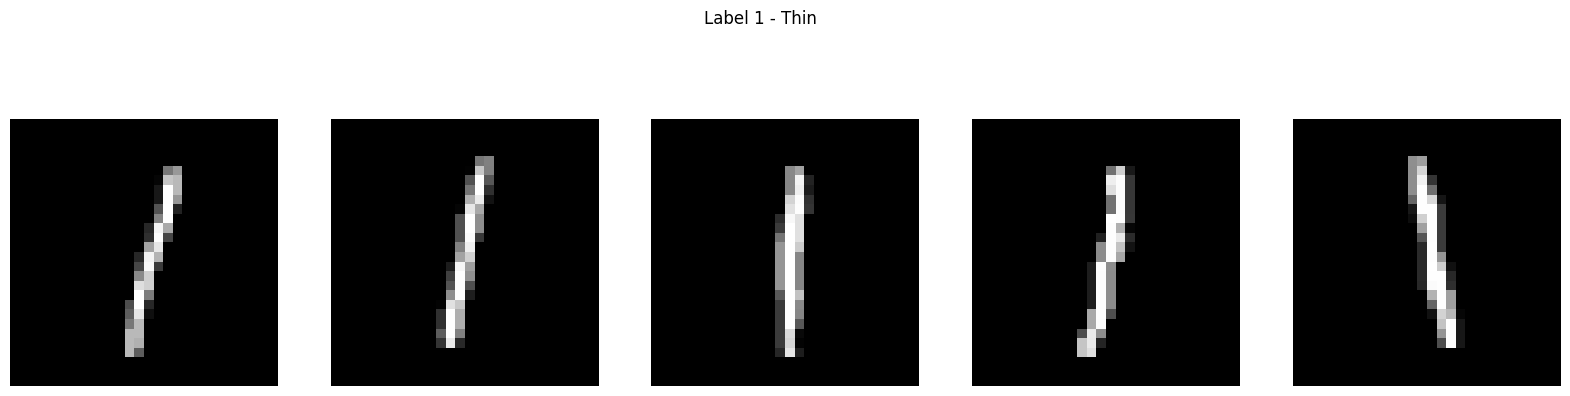

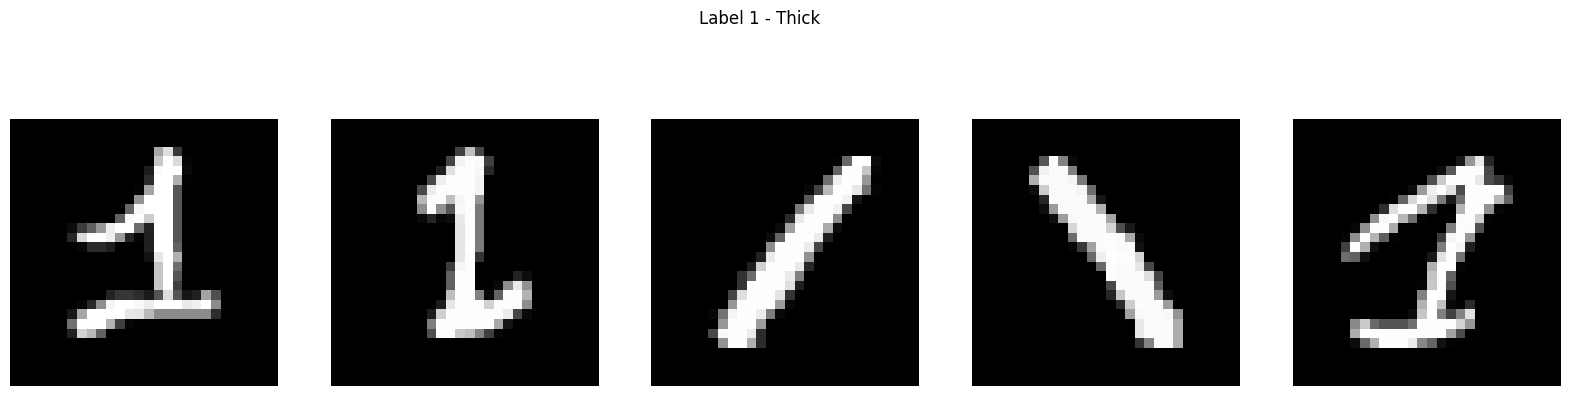

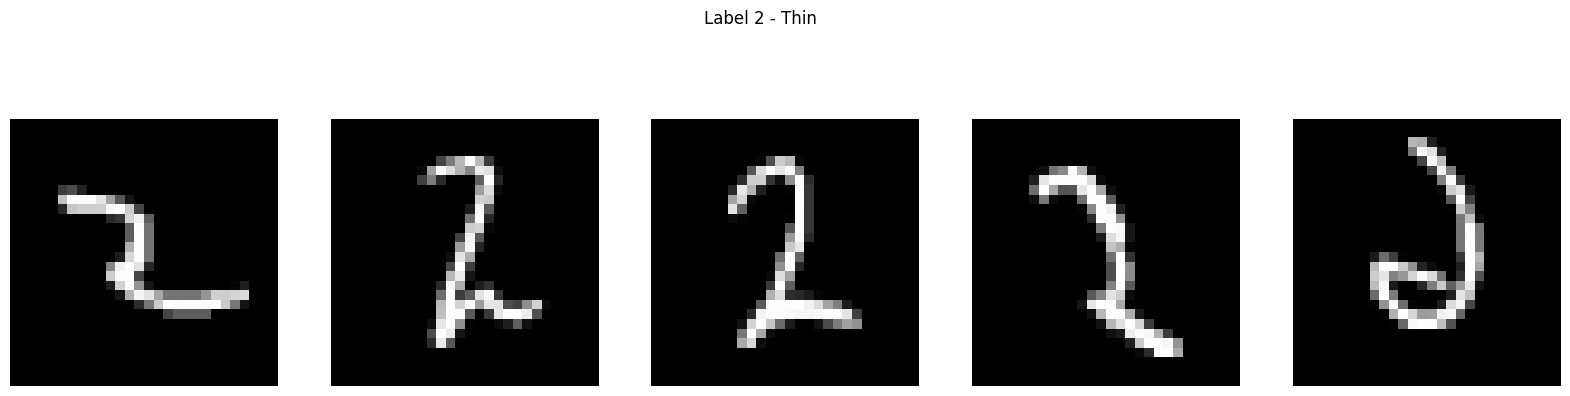

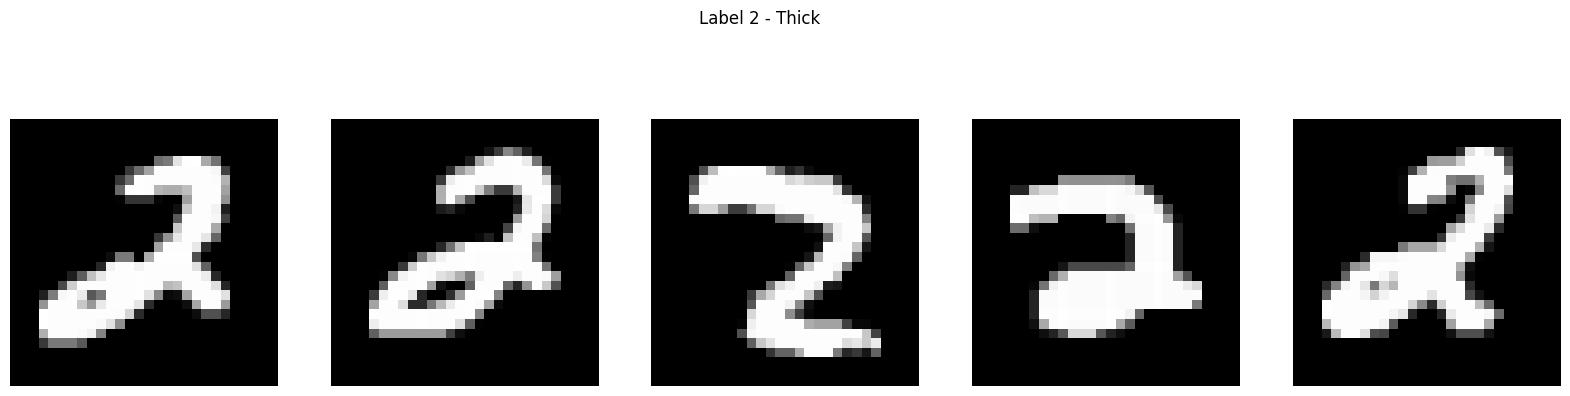

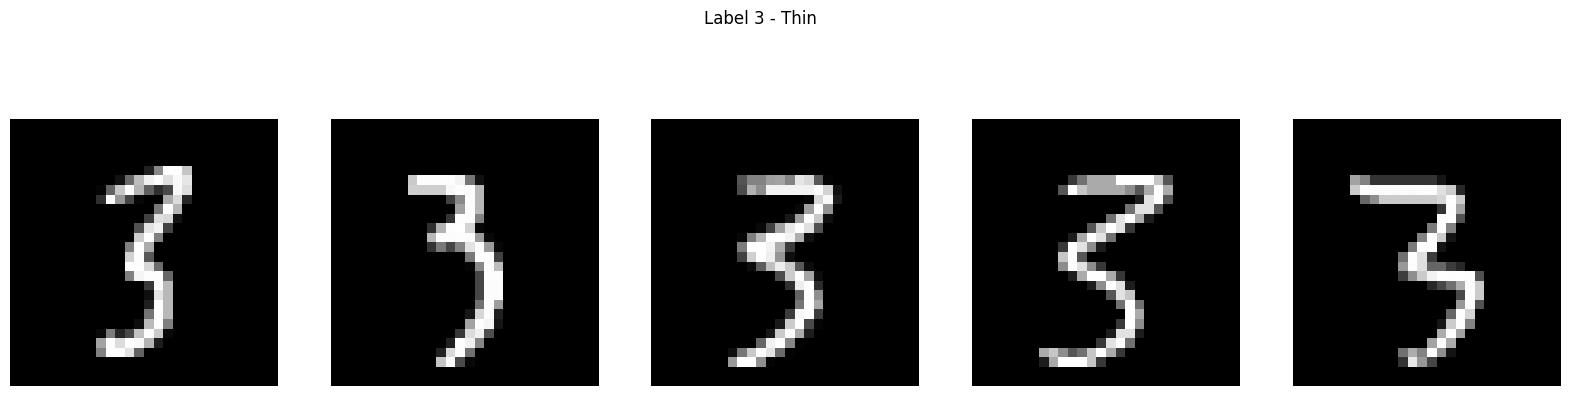

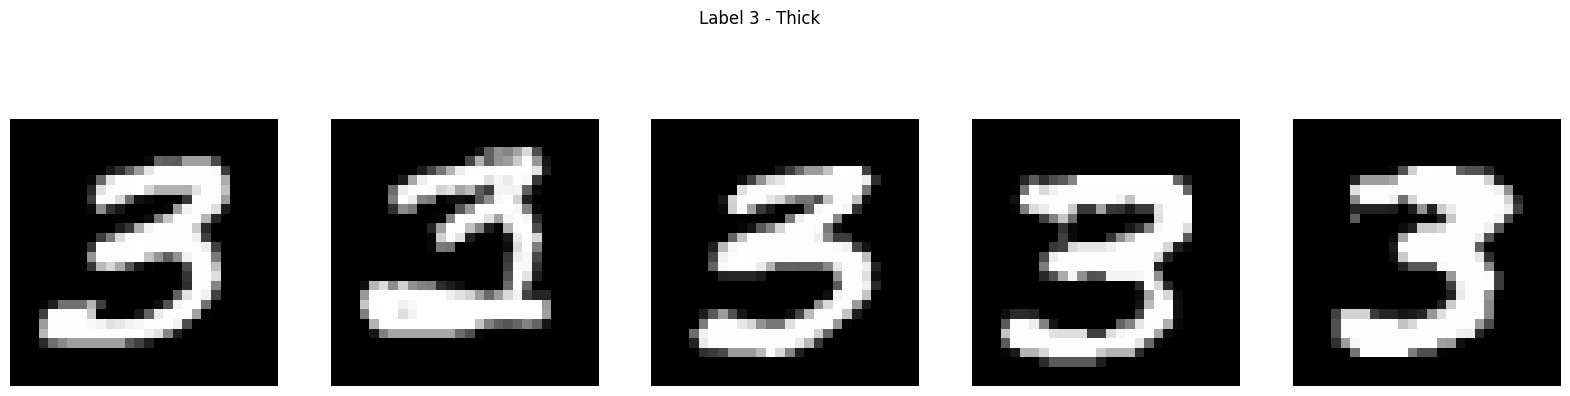

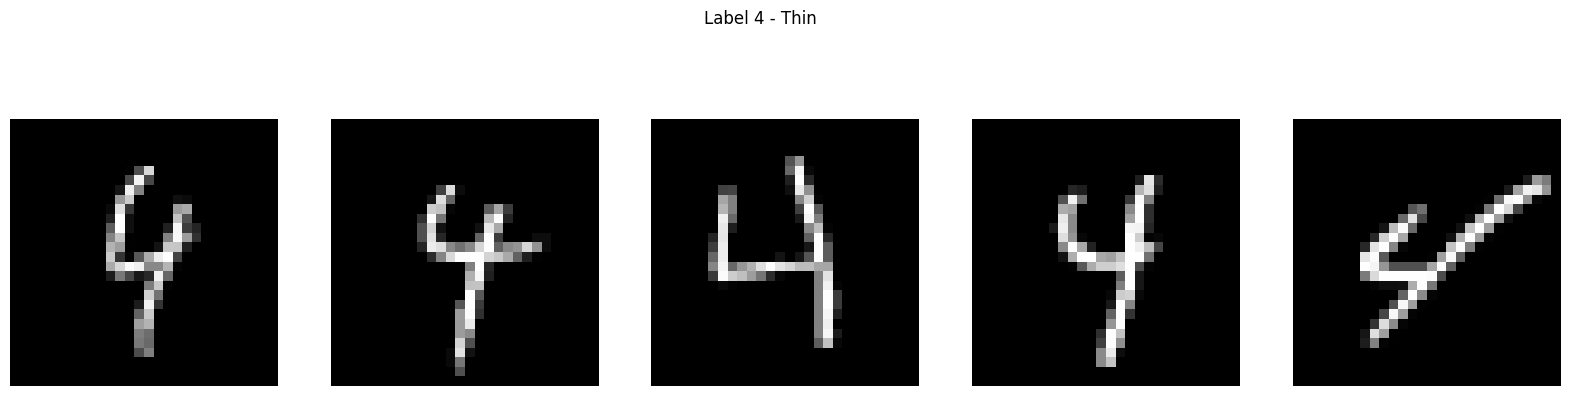

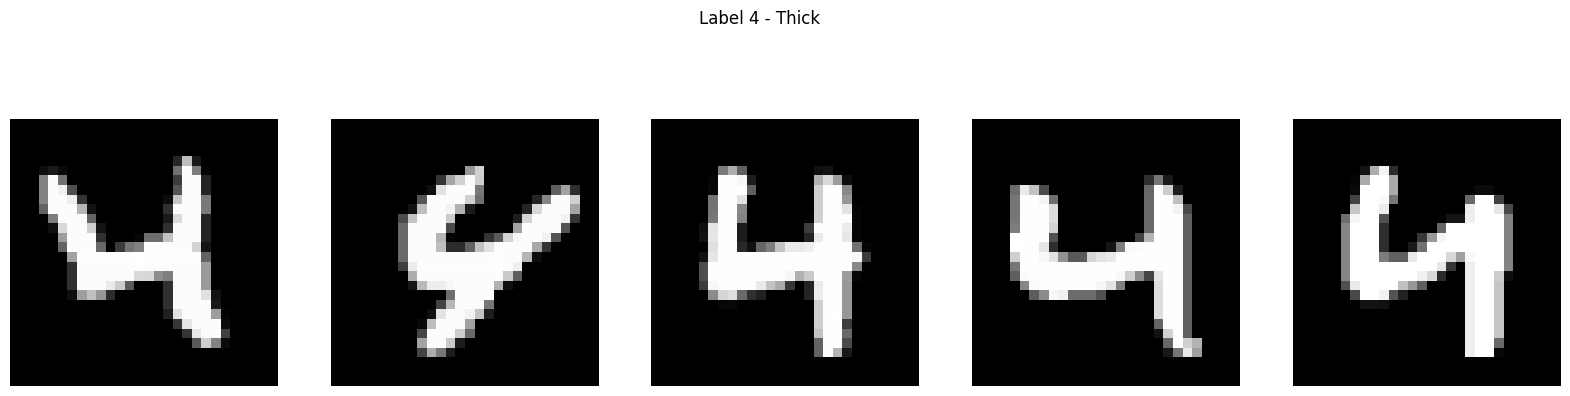

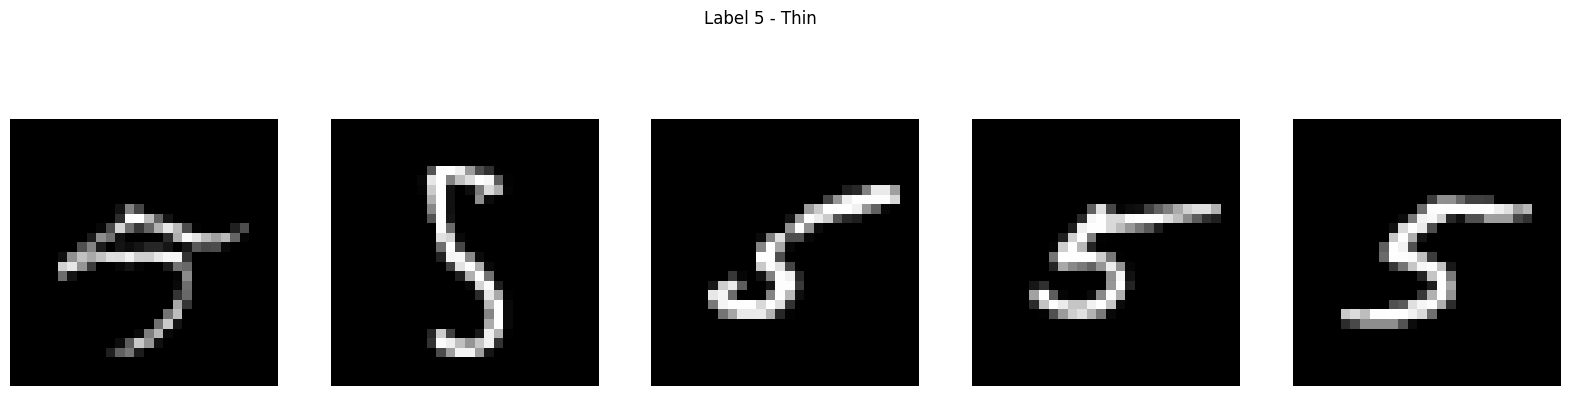

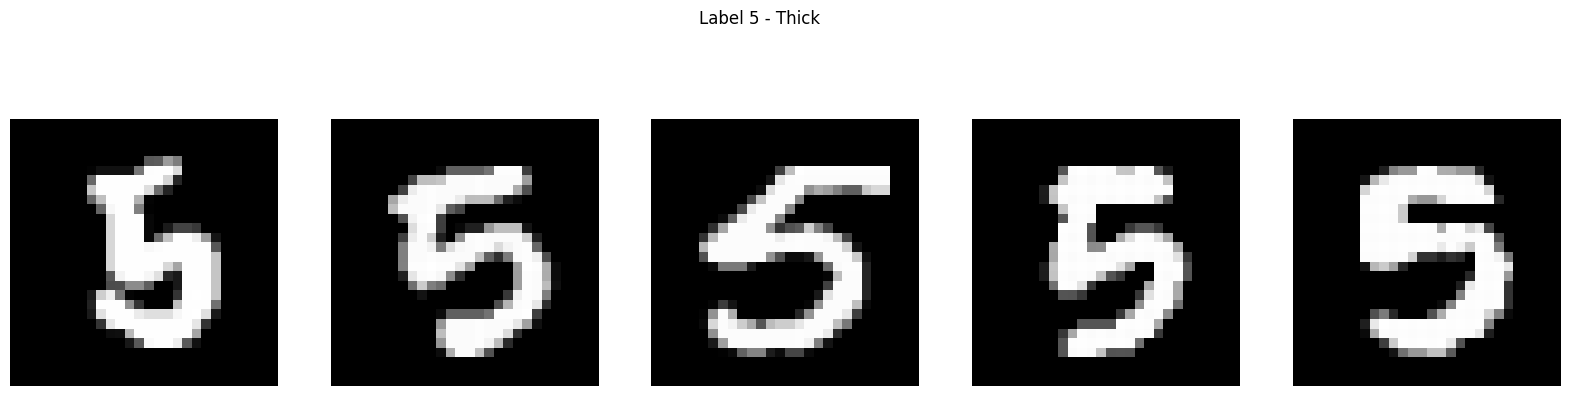

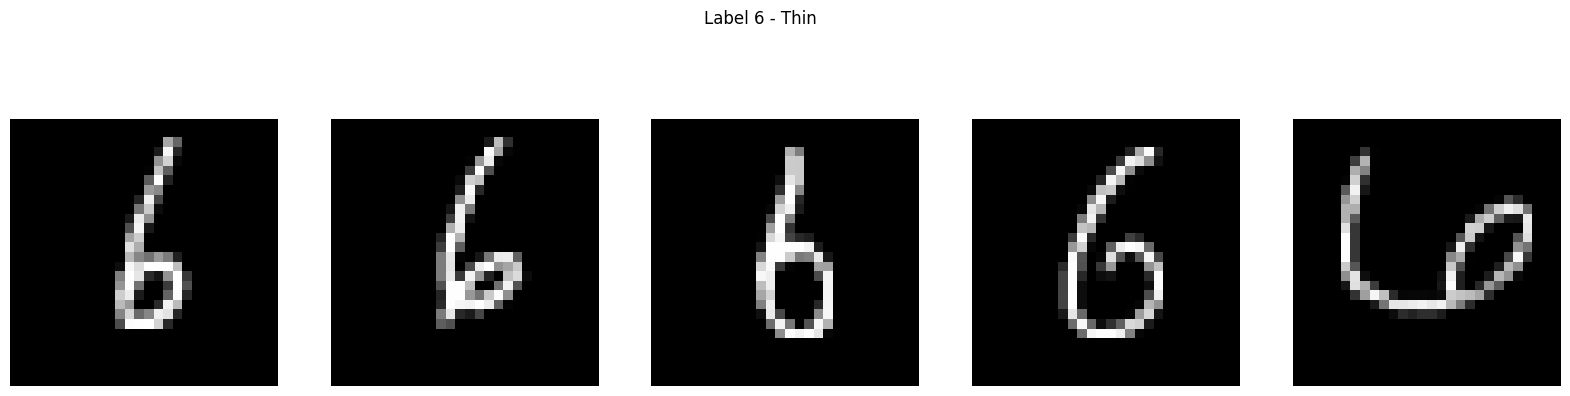

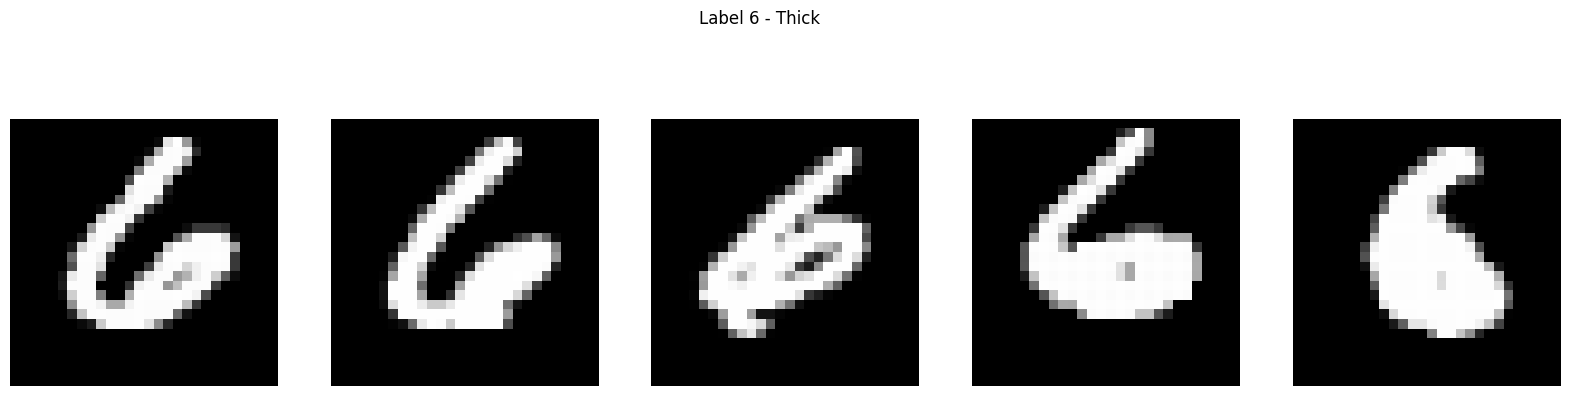

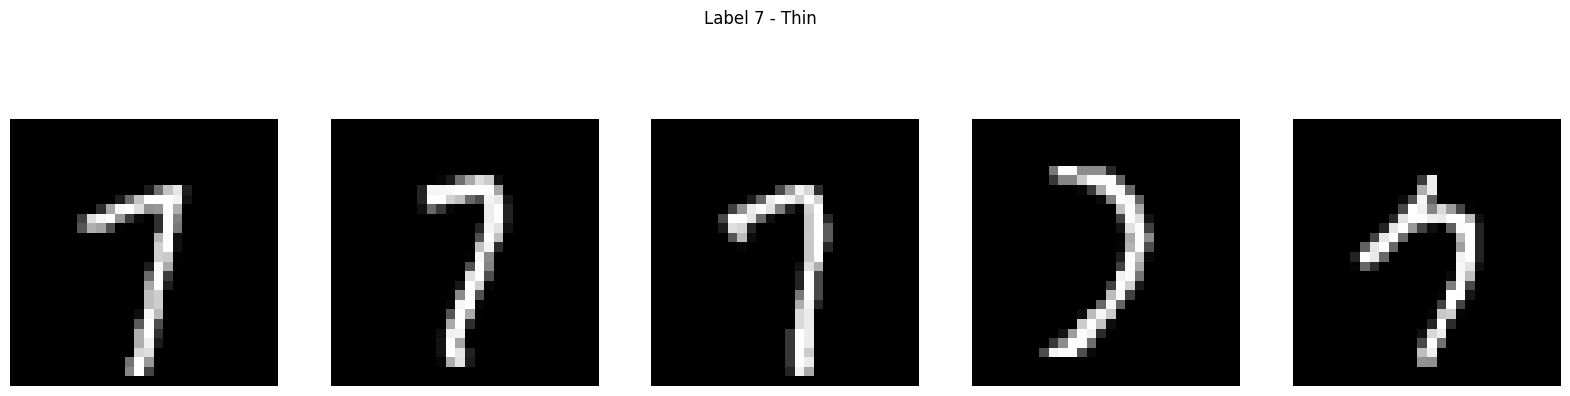

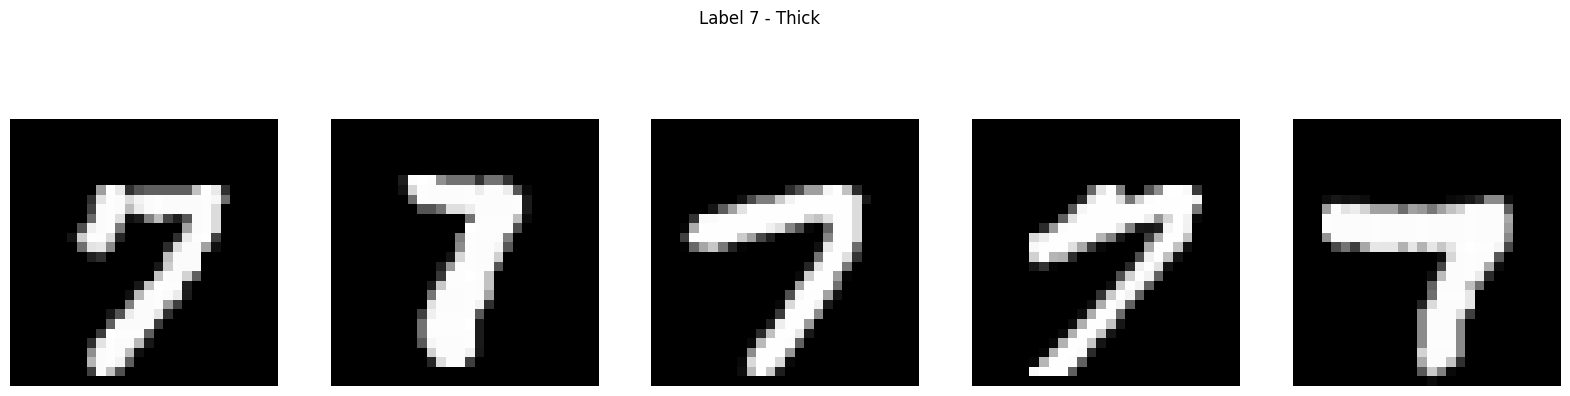

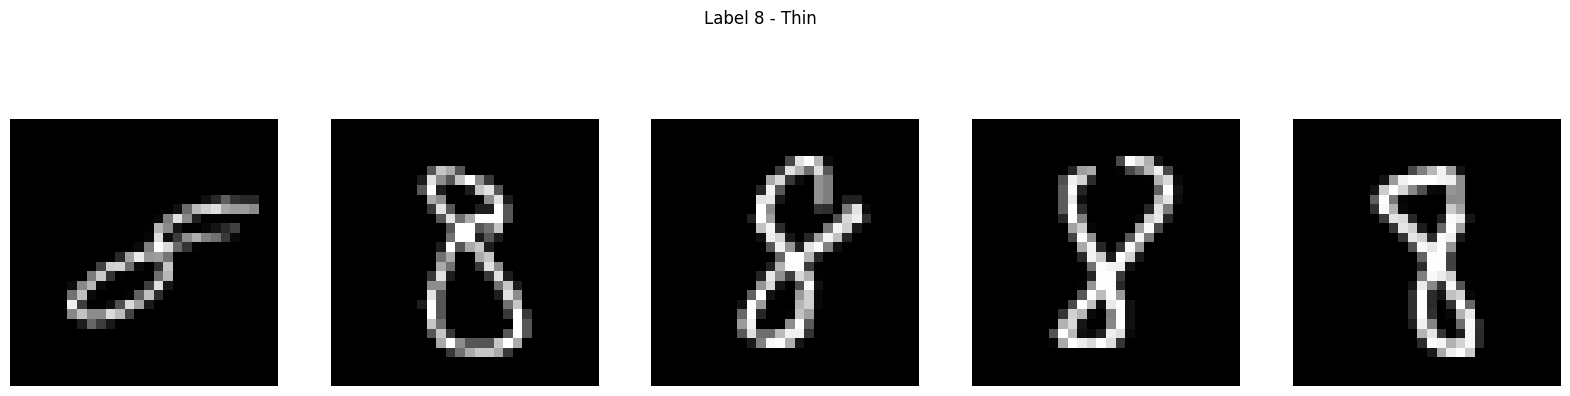

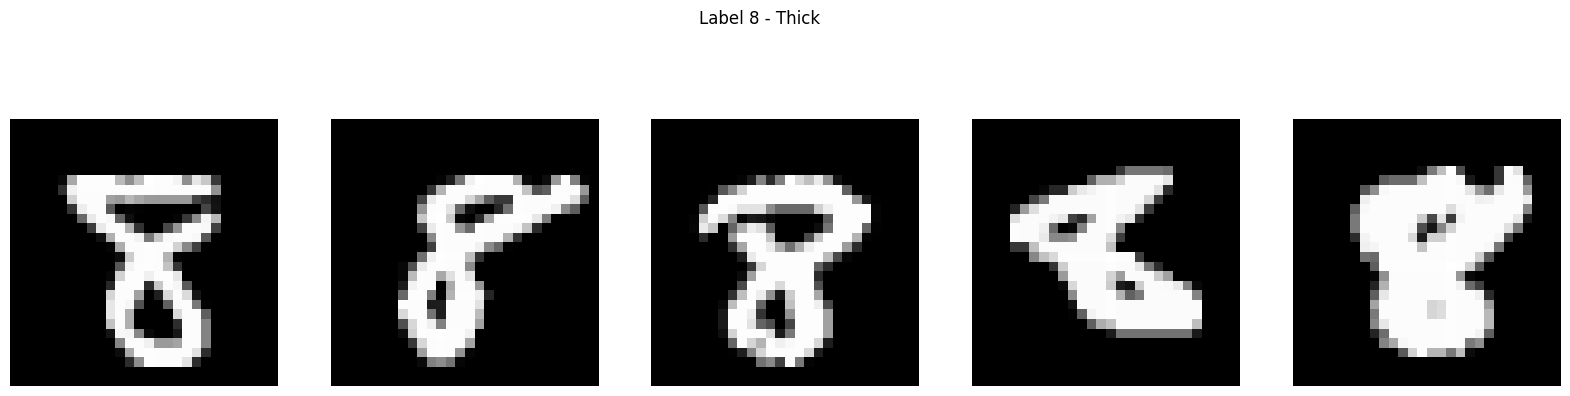

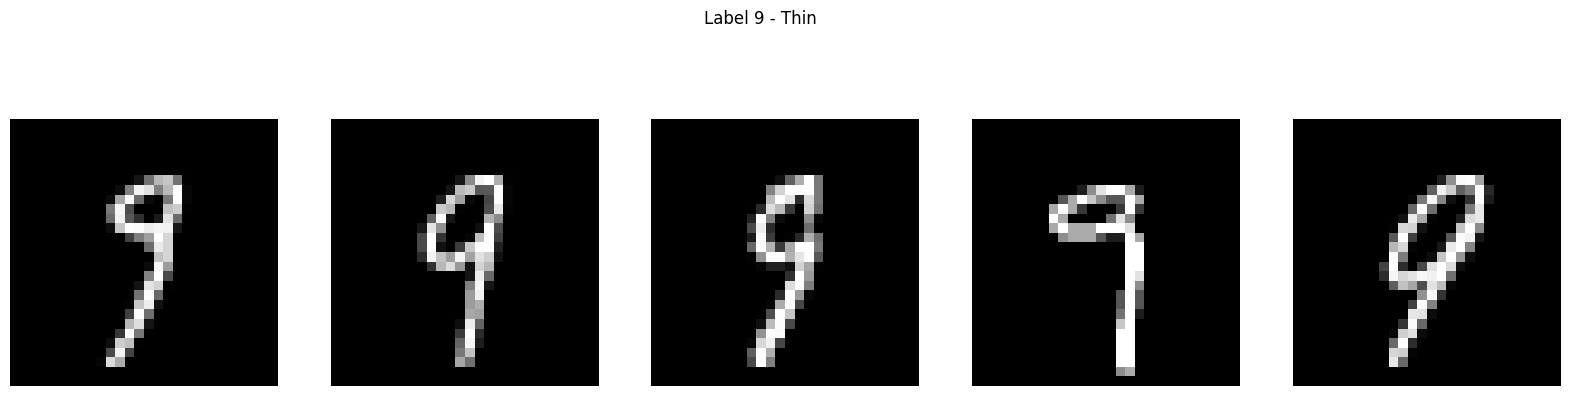

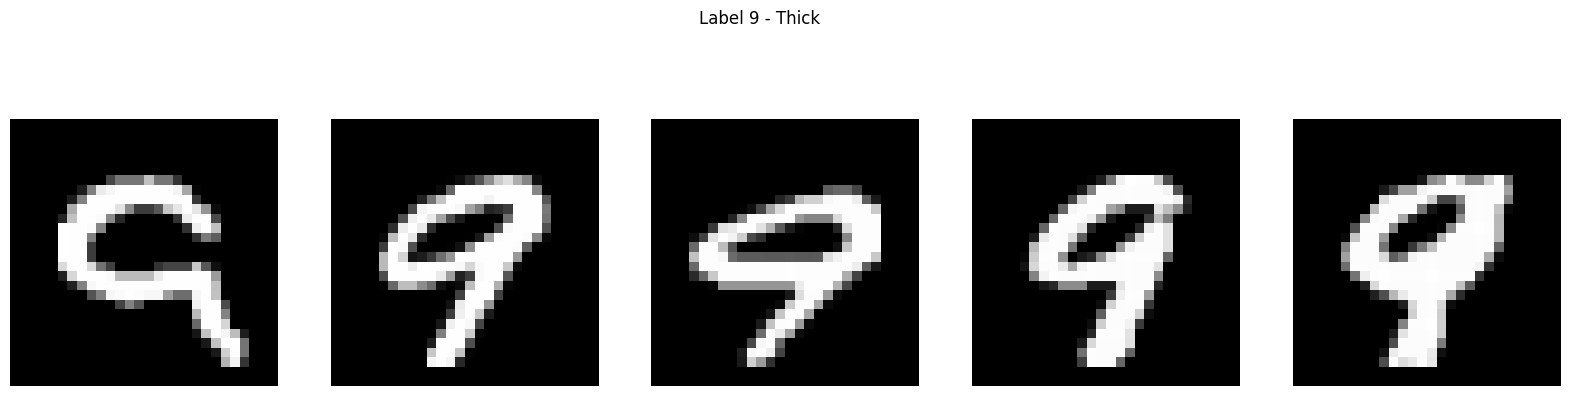

In [36]:
# Sample Images by Label
def sample_images_by_label(dataset, num_samples=1000):
    label_dict = {i: [] for i in range(10)}  # Labels 0-9
    for img, label in dataset:
        label_dict[label].append(img.numpy().squeeze())  # Remove channel dimension
    for label in label_dict:
        label_dict[label] = np.array(label_dict[label][:num_samples])
    return label_dict

# Compute Pixel Sums
def compute_pixel_sums(images):
    return images.reshape(images.shape[0], -1).sum(axis=1)  # Sum over all pixels

# Select Extremes
def select_extremes(images, pixel_sums, num_extremes=100):
    sorted_indices = np.argsort(pixel_sums)
    thin_indices = sorted_indices[:num_extremes]
    thick_indices = sorted_indices[-num_extremes:]
    return images[thin_indices], images[thick_indices]

# Generate Pair Dataset and Plot
def generate_thin_thick_images(dataset, num_samples=100, num_extremes=5):
    label_dict = sample_images_by_label(dataset, num_samples)
    thin_image = []
    thick_image = []
    for label, images in label_dict.items():
        pixel_sums = compute_pixel_sums(images)
        thin_images, thick_images = select_extremes(images, pixel_sums, num_extremes)

        thin_image.append(thin_images)
        thick_image.append(thick_images)
        # Plot Thin Images
        plt.figure(figsize=(num_extremes*4, 5))
        for i in range(num_extremes):
            plt.subplot(1, num_extremes, i + 1)
            plt.imshow(thin_images[i], cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Label {label} - Thin")
        plt.show()

        # Plot Thick Images
        plt.figure(figsize=(num_extremes*4, 5))
        for i in range(num_extremes):
            plt.subplot(1, num_extremes, i + 1)
            plt.imshow(thick_images[i], cmap='gray')
            plt.axis('off')
        plt.suptitle(f"Label {label} - Thick")
        plt.show()

    thin_image  = [pair for sublist in thin_image for pair in sublist]
    thick_image = [pair for sublist in thick_image for pair in sublist]
    return  thin_image, thick_image

# Run the function
thin_images, thick_images = generate_thin_thick_images(dataset)

In [37]:
def identify_direction(generator, thick_samples, thin_samples, latent_dim, steps=200, device=device):

    generator.eval()  # Ensure generator is in evaluation mode

    thick_latents = []
    thin_latents = []

    # Process thick samples to get their latent vectors
    for sample in thick_samples:
        latent, _ = invert_to_latent_vector(generator, sample, latent_dim, device, num_steps=steps)
        thick_latents.append(latent)

    # Process thin samples to get their latent vectors
    for sample in thin_samples:
        latent, _ = invert_to_latent_vector(generator, sample, latent_dim, device, num_steps=steps)
        thin_latents.append(latent)

    # Stack latents into tensors for pairwise computation
    thick_latents = torch.stack(thick_latents)
    thin_latents = torch.stack(thin_latents)

    # Ensure both sets have the same number of samples
    num_pairs = min(len(thick_latents), len(thin_latents))
    thick_latents = thick_latents[:num_pairs]
    thin_latents = thin_latents[:num_pairs]

    # Compute pairwise differences and average them
    differences = thick_latents - thin_latents
    direction = torch.mean(differences, dim=0)

    return direction

def modify_attribute(generator, original_latent, direction, alpha, device):
    generator.eval()
    modified_latent = original_latent + alpha * direction
    modified_sample = generator(modified_latent)
    return modified_sample

def plot_modified_images(generator, dataloader, direction, latent_dim, alpha_values, device, num_samples=5, steps = 500):
    generator.eval()

    # Get samples from the dataloader
    samples, labels = next(iter(dataloader))
    samples = samples[:num_samples].to(device)

    # Invert images to latent space
    latents = [invert_to_latent_vector(generator, sample, latent_dim, device ,num_steps=steps )[0] for sample in samples]

    # Set up the plot
    fig, axes = plt.subplots(num_samples, len(alpha_values)+1, figsize=(5*(len(alpha_values)+1), 5 * num_samples))
    for i, (latent, original_image) in enumerate(zip(latents, samples)):
        # Prepare original image for plotting
        original_image = original_image.cpu().squeeze().numpy()

        # Plot the original image
        axes[i, 0].imshow(original_image, cmap="gray")
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        for j, alpha in enumerate(alpha_values):
            # Modify the latent vector and generate a modified image
            modified_sample = modify_attribute(generator, latent, direction, alpha, device)
            modified_image = modified_sample.cpu().squeeze().detach().numpy()

            # Plot the modified image
            axes[i, j + 1].imshow(modified_image, cmap="gray")
            axes[i, j + 1].set_title(f"Alpha {alpha}")
            axes[i, j + 1].axis("off")

    plt.tight_layout()
    plt.show()

In [38]:
# Calculate direction vector
direction = identify_direction(generator, thick_images, thin_images, latent_dim, device=device, steps=500)

<ipython-input-34-82720171e7a1>:45: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(generated_image_resized, real_image)


Step [0/500], Loss: 0.7418798804283142
Step [100/500], Loss: 0.15709829330444336
Step [200/500], Loss: 0.1404770314693451
Step [300/500], Loss: 0.12334230542182922
Step [400/500], Loss: 0.12043223530054092
Step [0/500], Loss: 0.5507708191871643
Step [100/500], Loss: 0.21981939673423767
Step [200/500], Loss: 0.1543494462966919
Step [300/500], Loss: 0.13137975335121155
Step [400/500], Loss: 0.12159176915884018
Step [0/500], Loss: 0.8872267603874207
Step [100/500], Loss: 0.8428220152854919
Step [200/500], Loss: 0.8370450139045715
Step [300/500], Loss: 0.8340429067611694
Step [400/500], Loss: 0.8325263857841492
Step [0/500], Loss: 0.723042368888855
Step [100/500], Loss: 0.17874090373516083
Step [200/500], Loss: 0.14972132444381714
Step [300/500], Loss: 0.13943736255168915
Step [400/500], Loss: 0.13677802681922913
Step [0/500], Loss: 0.5986630320549011
Step [100/500], Loss: 0.11289387941360474
Step [200/500], Loss: 0.09933291375637054
Step [300/500], Loss: 0.09364637732505798
Step [400/500]

<ipython-input-34-82720171e7a1>:45: UserWarning: Using a target size (torch.Size([1, 28, 28])) that is different to the input size (torch.Size([1, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(generated_image_resized, real_image)


Step [0/500], Loss: 0.5266367197036743
Step [100/500], Loss: 0.4089870750904083
Step [200/500], Loss: 0.3664896488189697
Step [300/500], Loss: 0.1801804155111313
Step [400/500], Loss: 0.10354367643594742
Step [0/500], Loss: 0.8024742007255554
Step [100/500], Loss: 0.36920928955078125
Step [200/500], Loss: 0.08962686359882355
Step [300/500], Loss: 0.0870259627699852
Step [400/500], Loss: 0.08605074882507324
Step [0/500], Loss: 0.48370254039764404
Step [100/500], Loss: 0.09233555942773819
Step [200/500], Loss: 0.08519487082958221
Step [300/500], Loss: 0.08028487861156464
Step [400/500], Loss: 0.07804612815380096
Step [0/500], Loss: 0.6834206581115723
Step [100/500], Loss: 0.36139342188835144
Step [200/500], Loss: 0.30780428647994995
Step [300/500], Loss: 0.2985212504863739
Step [400/500], Loss: 0.25603508949279785
Step [0/500], Loss: 0.7969269752502441
Step [100/500], Loss: 0.773216724395752
Step [200/500], Loss: 0.764801025390625
Step [300/500], Loss: 0.7546992301940918
Step [400/500], 

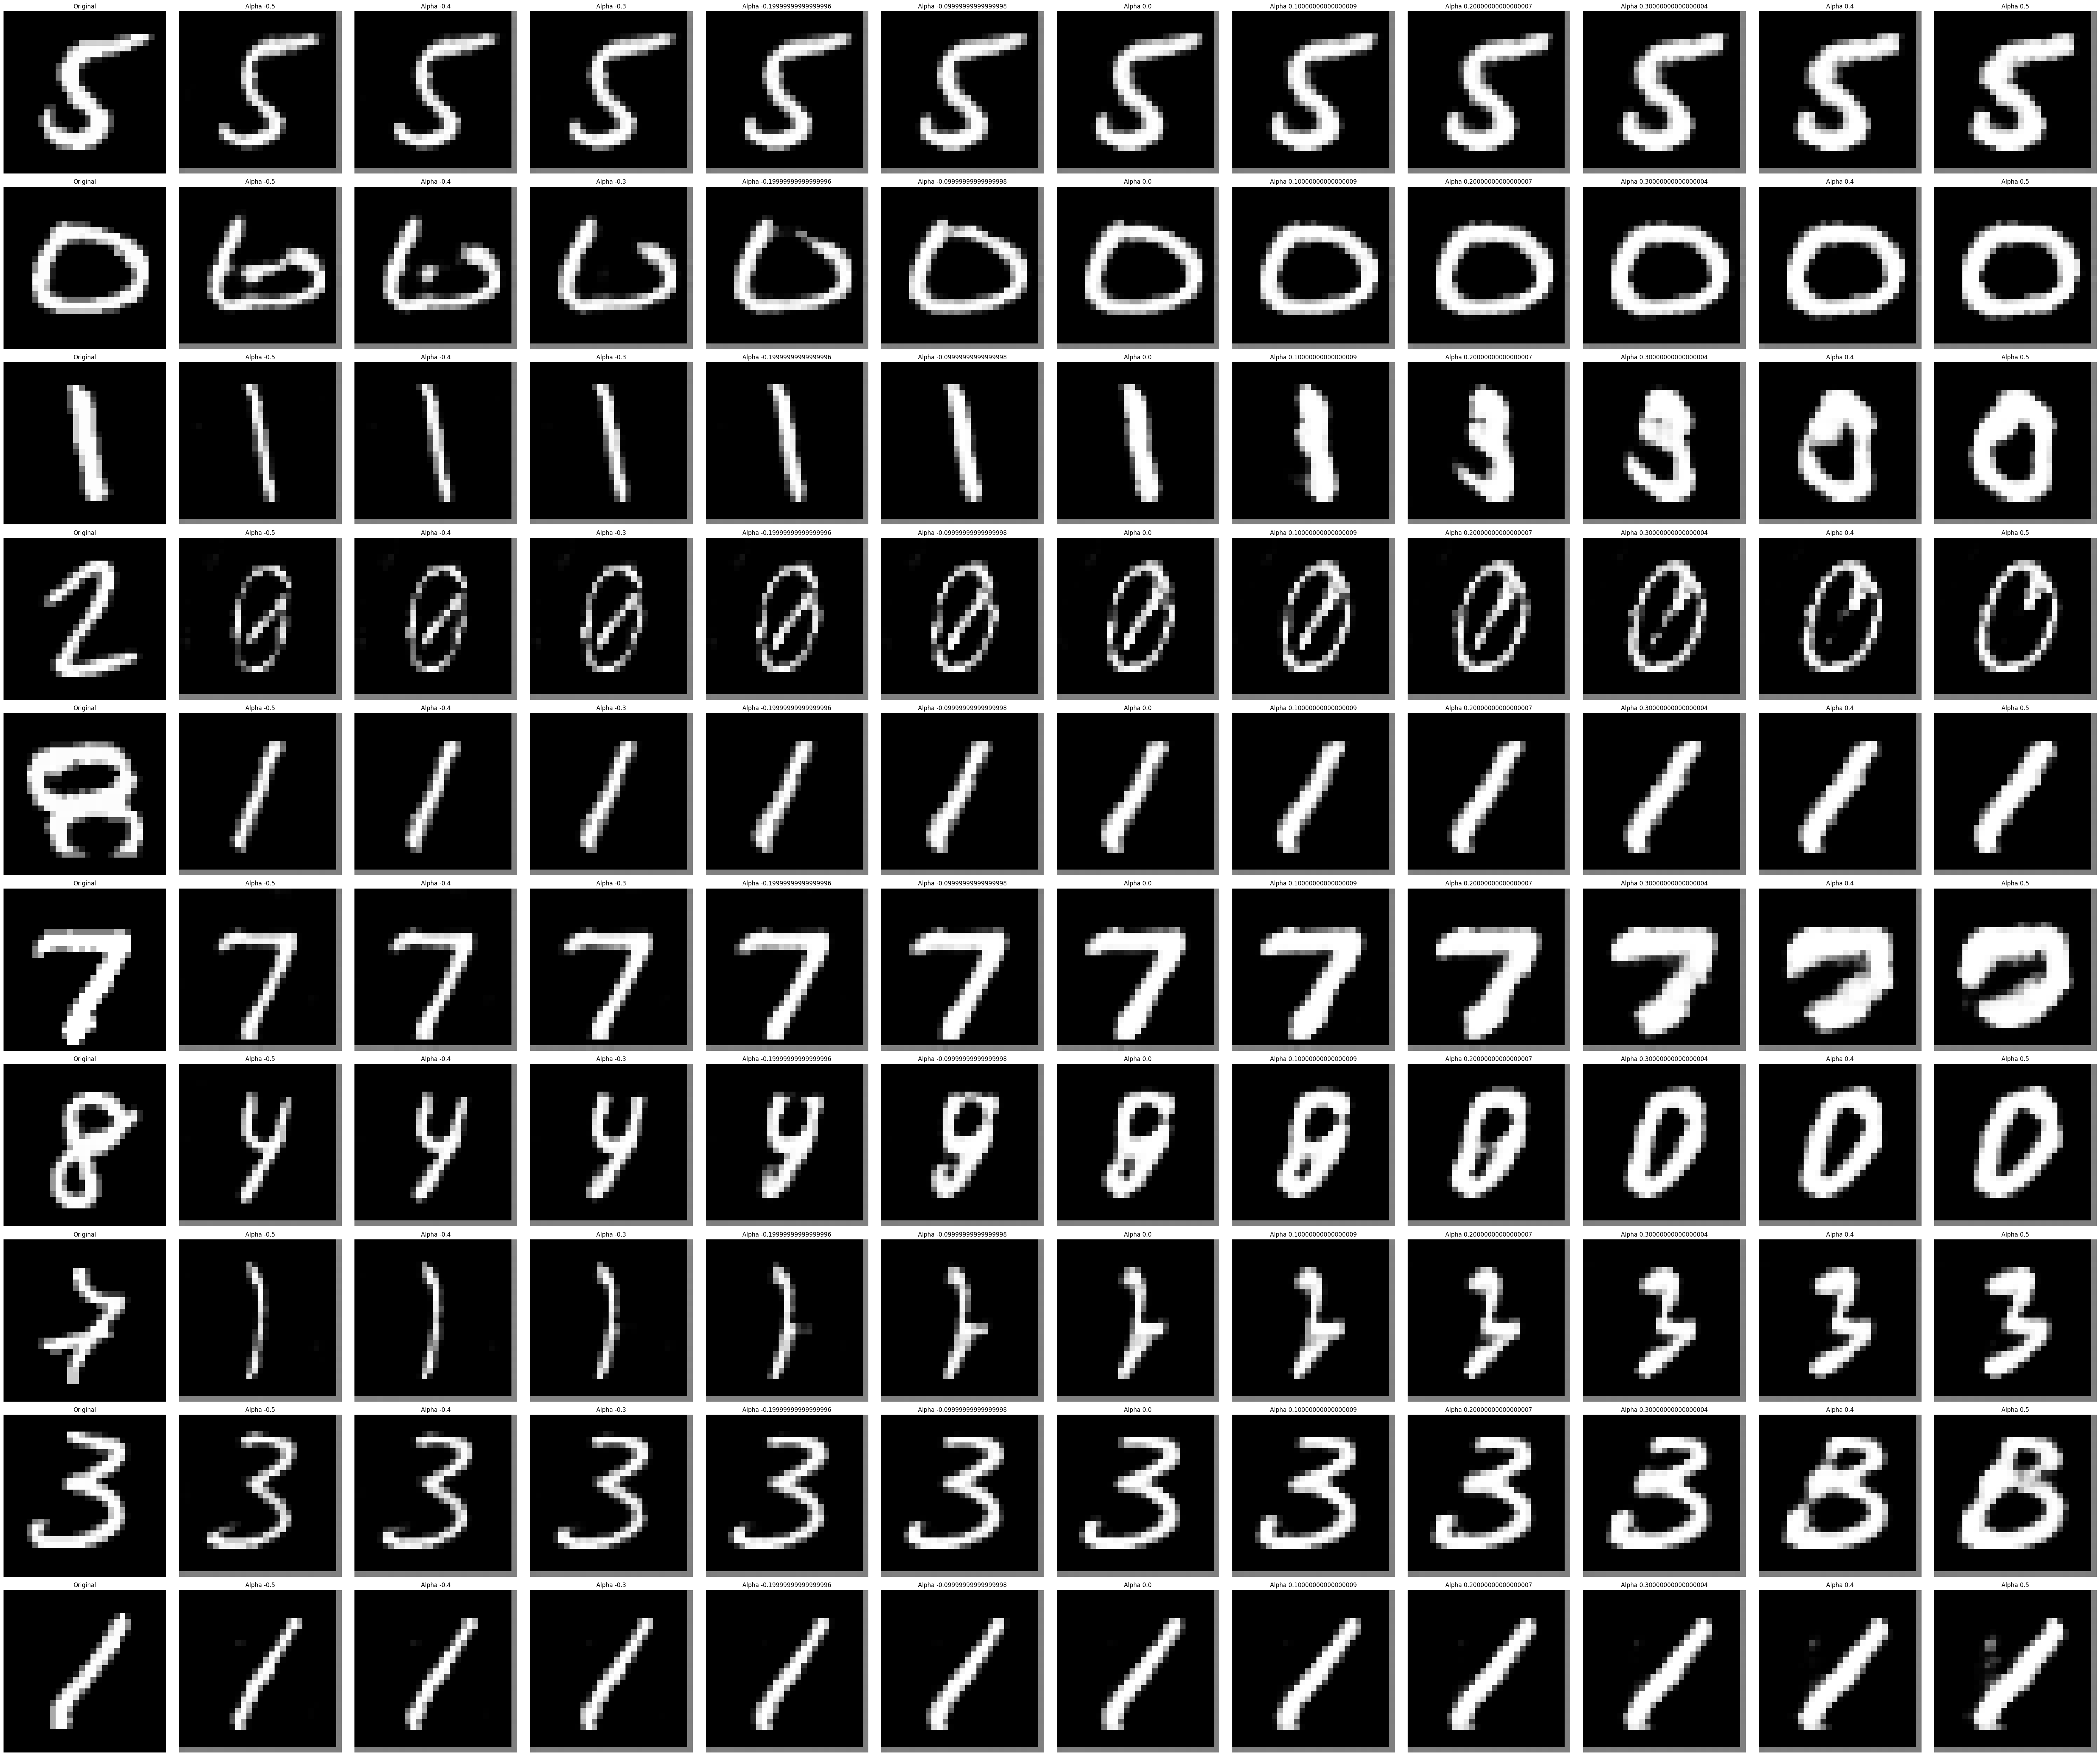

In [39]:
# Modify and visualize images
alpha_values = np.linspace(-0.5,0.5,11)
plot_modified_images(generator, train_loader, direction, latent_dim, alpha_values, device=device, num_samples=10, steps = 500)

# Latent Space Analysis and Transformations

## **1. Computing Class Latent Averages**
**Function**: `compute_class_latents`  
This function calculates the **average latent vector** for each class, representing its general characteristics in the latent space.

### **Steps**:
1. **Initialize Class Storage**:
   - Creates a dictionary `class_latents` with class labels (0-9) as keys and lists to store latent vectors.

2. **Sample Latents by Class**:
   - For each image:
     - Determine the class label.
     - Use **GAN inversion** (`invert_to_latent_vector`) to compute its latent vector.
     - Store the latent vector in the dictionary until the desired number of samples (`num_samples`) is reached.

3. **Compute Averages**:
   - Averages the latent vectors for each class to create `class_avg_latents`, mapping each class to its **average latent vector**.

---

## **2. Calculating Transformation Directions**
**Function**: `calculate_class_directions`  
This function determines latent space **directions** to transform samples from one class into another.

### **Steps**:
1. **Select Target Class**:
   - Identify the average latent vector for the `target_class` from `class_avg_latents`.

2. **Compute Directions**:
   - For each class in `source_classes`:
     - Compute the difference between the source class's average latent vector and the target class's average latent vector:  
       **Direction** = Target Latent - Source Latent

3. **Store Directions**:
   - Save the computed directions in a dictionary, `directions`, mapping each source class to its transformation direction.

---

## **3. Applying the Mean Direction**
**Function**: `plot_transformations_with_mean_direction`  
This function applies a **mean transformation direction** to modify latent vectors and visualizes the results.

### **Steps**:
1. **Calculate Mean Direction**:
   - Average all directions in `directions` to obtain a single **mean direction**:  
     **Mean Direction** = Average of All Directions.

2. **Map Samples to Latent Space**:
   - Convert input samples into latent vectors using GAN inversion.

3. **Apply Transformations**:
   - Modify latent vectors by adding the scaled mean direction:  
     **Modified Latent** = Original Latent +  \( \alpha \times \text{Mean Direction} \),  
     where \( \alpha \) is a scaling factor controlling transformation intensity.

4. **Generate and Plot Images**:
   - For each sample:
     - Display the original image.
     - Generate and display transformed images corresponding to different \( \alpha \) values.


In [40]:
def compute_class_latents(generator, dataset, latent_dim, device, num_samples=100, steps=200):
    class_latents = {i: [] for i in range(10)}

    # Sample images by class
    for img, label in dataset:
        if len(class_latents[label]) < num_samples:
            latent, _ = invert_to_latent_vector(generator, img.unsqueeze(0), latent_dim, device, num_steps=steps)
            class_latents[label].append(latent)

    # Compute the average latent vector for each class
    class_avg_latents = {
        label: torch.mean(torch.stack(latents), dim=0)
        for label, latents in class_latents.items()
    }

    return class_avg_latents

def calculate_class_directions(class_avg_latents, source_classes, target_class):
    directions = {}
    target_latent = class_avg_latents[target_class]
    for source_class in source_classes:
        source_latent = class_avg_latents[source_class]
        directions[source_class] = target_latent - source_latent
    return directions

def plot_transformations_with_mean_direction(generator, samples, latent_dim, directions, alphas, device):
    generator.eval()

    # Compute the mean direction
    mean_direction = torch.mean(torch.stack(list(directions.values())), dim=0)

    # Invert samples to latent space
    latents = [invert_to_latent_vector(generator, sample.unsqueeze(0), latent_dim, device)[0] for sample in samples]

    num_samples = len(samples)
    fig, axes = plt.subplots(num_samples, len(alphas) + 1, figsize=(5 * (len(alphas) + 1), 3 * num_samples))

    for i, (latent, original_image) in enumerate(zip(latents, samples)):
        original_image = original_image.squeeze().cpu().numpy()

        # Plot the original image
        axes[i, 0].imshow(original_image, cmap="gray")
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        for j, alpha in enumerate(alphas):
            # Modify the latent vector using the mean direction
            modified_latent = latent + alpha * mean_direction
            modified_image = generator(modified_latent).squeeze().cpu().detach().numpy()

            # Plot the modified image
            axes[i, j + 1].imshow(modified_image, cmap="gray")
            axes[i, j + 1].set_title(f"Alpha {alpha}")
            axes[i, j + 1].axis("off")

    plt.tight_layout()
    plt.show()


In [41]:
# Compute average latent vectors for each class
class_avg_latents = compute_class_latents(generator, dataset, latent_dim, device, num_samples=10, steps=200)

# Define source classes and target class
source_classes = [0, 1, 2, 4, 5, 6, 7, 8, 9]  # Example source classes
target_class = 3  # Target class

# Calculate directions for each source class to the target class
directions = calculate_class_directions(class_avg_latents, source_classes, target_class)

Step [0/200], Loss: 0.49215298891067505
Step [100/200], Loss: 0.34267884492874146
Step [0/200], Loss: 0.48811066150665283
Step [100/200], Loss: 0.09923841059207916
Step [0/200], Loss: 0.5470272302627563
Step [100/200], Loss: 0.38642004132270813
Step [0/200], Loss: 0.5735161900520325
Step [100/200], Loss: 0.12799818813800812
Step [0/200], Loss: 0.41961532831192017
Step [100/200], Loss: 0.15228620171546936
Step [0/200], Loss: 0.46869218349456787
Step [100/200], Loss: 0.14904801547527313
Step [0/200], Loss: 0.3977784514427185
Step [100/200], Loss: 0.14028200507164001
Step [0/200], Loss: 0.6969761848449707
Step [100/200], Loss: 0.4538259506225586
Step [0/200], Loss: 0.20492307841777802
Step [100/200], Loss: 0.08613564819097519
Step [0/200], Loss: 0.49415338039398193
Step [100/200], Loss: 0.3460746109485626
Step [0/200], Loss: 0.23251000046730042
Step [100/200], Loss: 0.10571365058422089
Step [0/200], Loss: 0.5333071351051331
Step [100/200], Loss: 0.21798503398895264
Step [0/200], Loss: 0.7

Step [0/200], Loss: 0.3597877621650696
Step [100/200], Loss: 0.26756608486175537
Step [0/200], Loss: 0.342011034488678
Step [100/200], Loss: 0.13186246156692505
Step [0/200], Loss: 0.4822746813297272
Step [100/200], Loss: 0.10367348790168762
Step [0/200], Loss: 0.5287802219390869
Step [100/200], Loss: 0.17196428775787354
Step [0/200], Loss: 0.6542381644248962
Step [100/200], Loss: 0.3518655002117157
Step [0/200], Loss: 0.5453593730926514
Step [100/200], Loss: 0.17763526737689972
Step [0/200], Loss: 0.6948778629302979
Step [100/200], Loss: 0.24696817994117737
Step [0/200], Loss: 0.4692475497722626
Step [100/200], Loss: 0.293770968914032
Step [0/200], Loss: 0.7662487030029297
Step [100/200], Loss: 0.11946401745080948
Step [0/200], Loss: 0.4726276397705078
Step [100/200], Loss: 0.2231447845697403


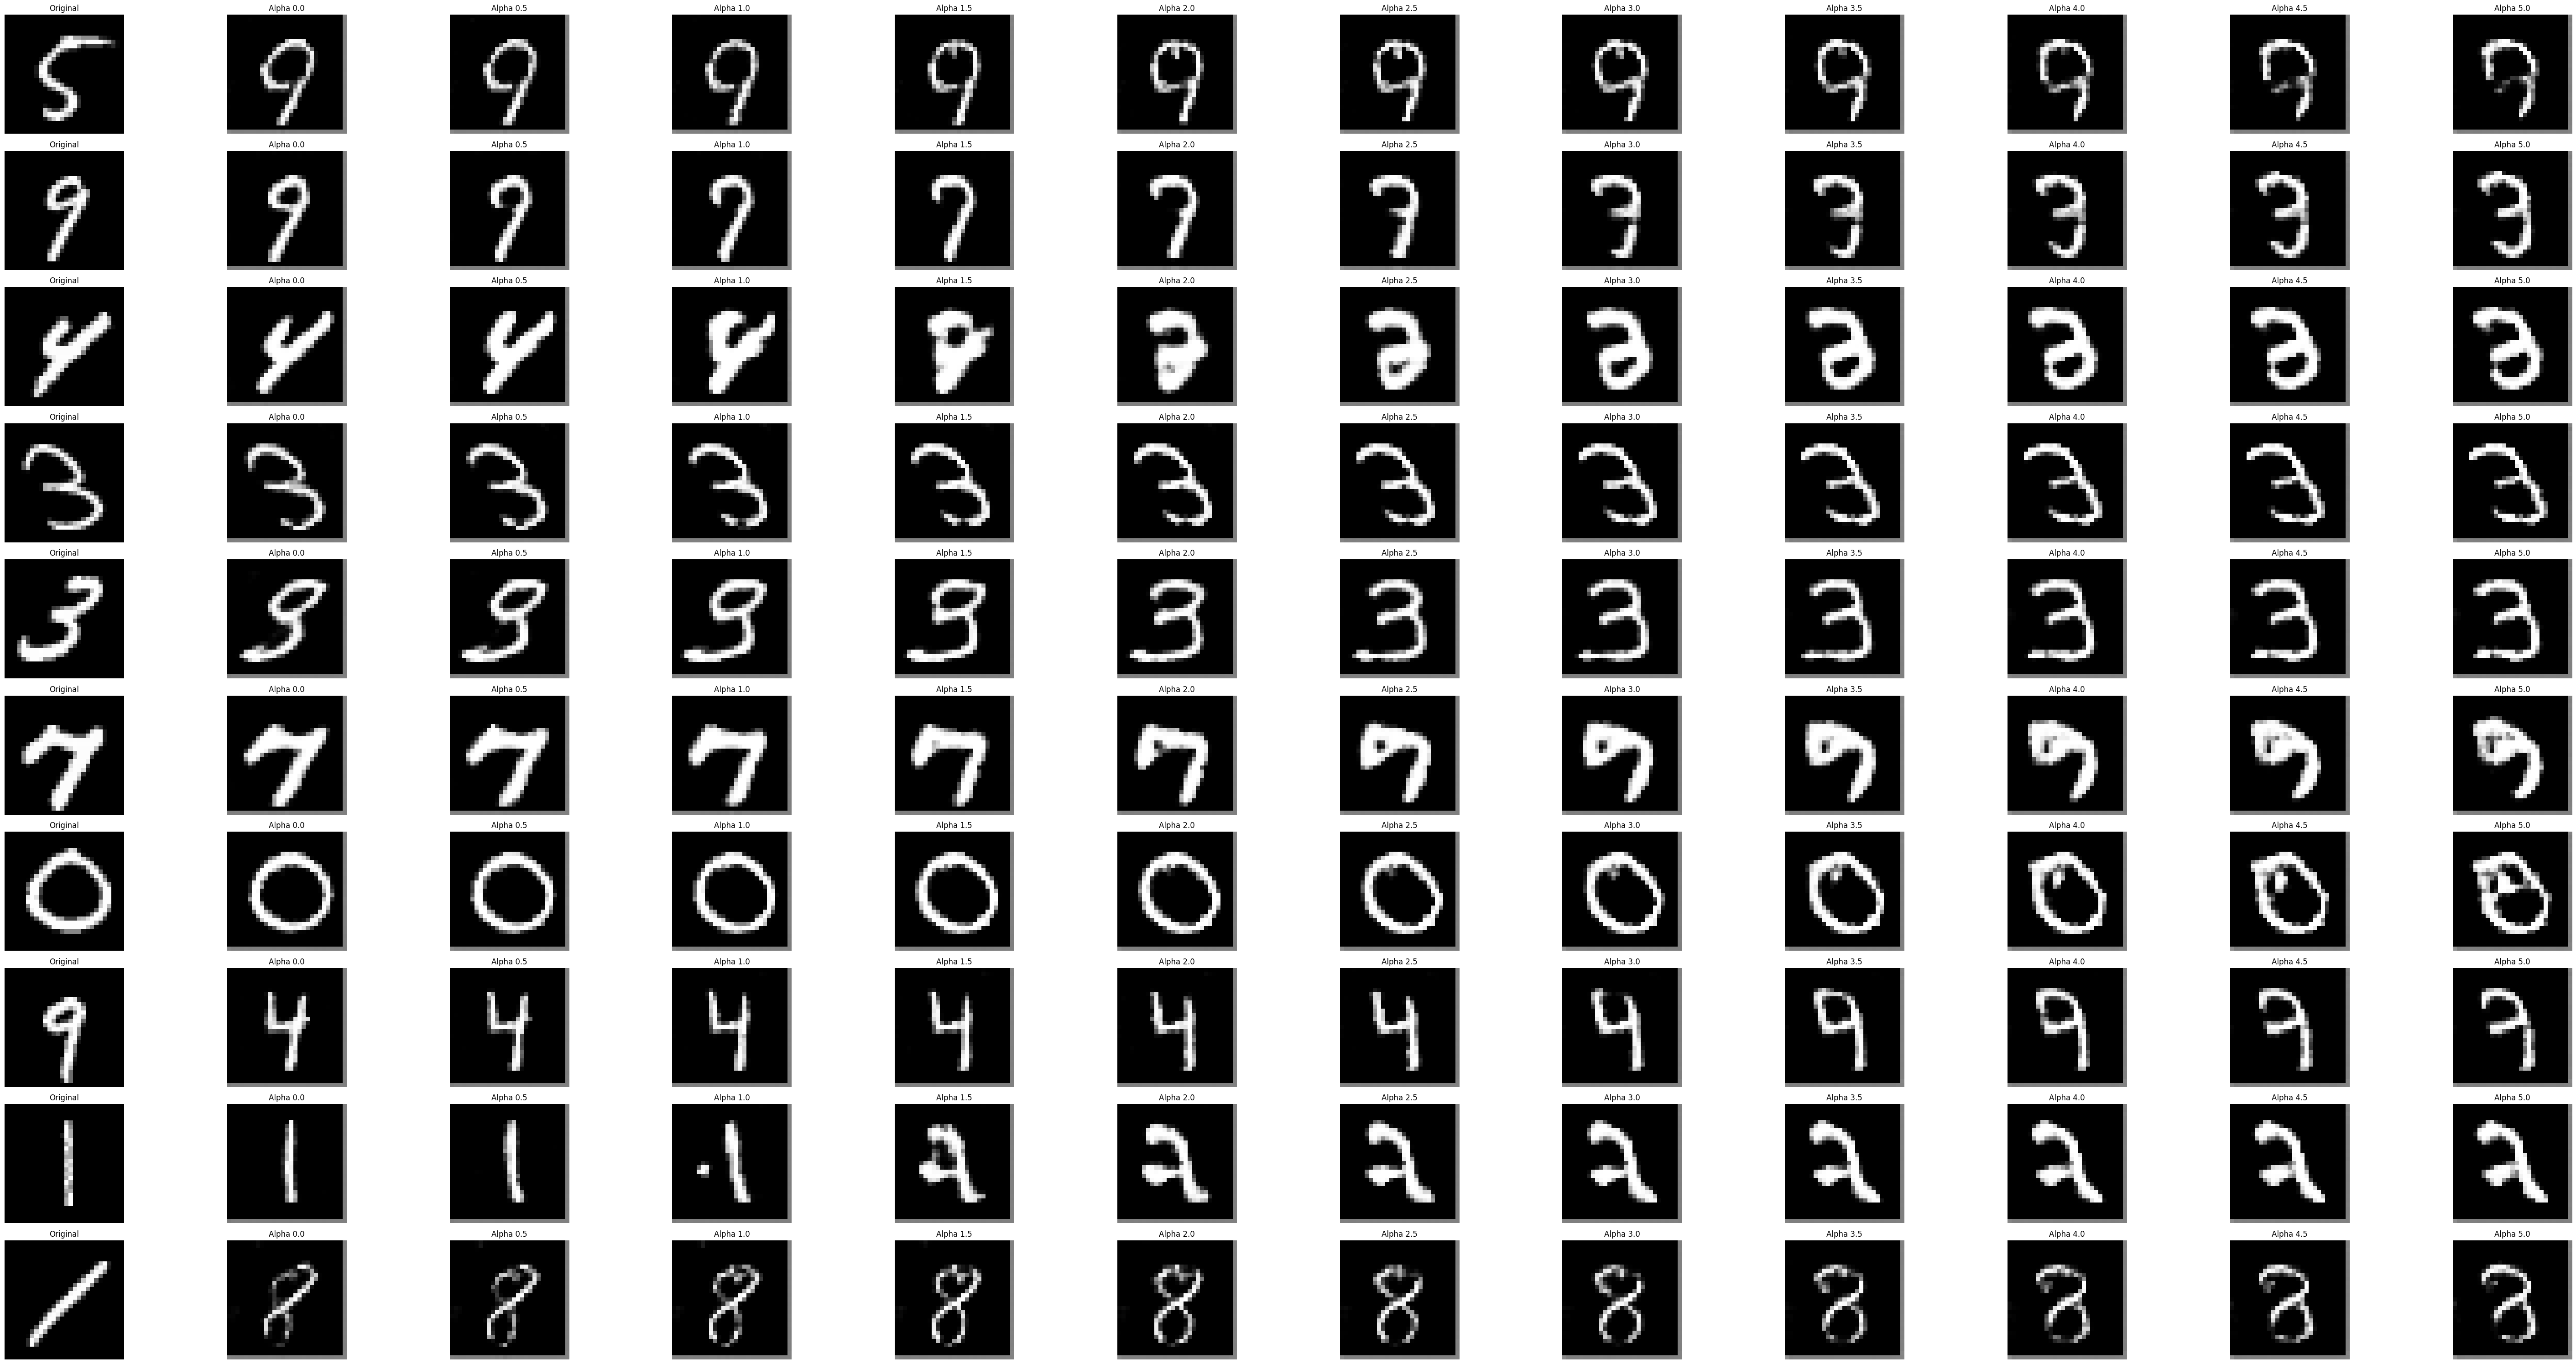

In [42]:
# Get a batch of samples
samples, _ = next(iter(train_loader))
samples = samples[:10].to(device)  # Take 5 samples for visualization
alphas = np.linspace(0, 5, 11)  # Alphas for transformation

# Plot transformations using the mean direction
plot_transformations_with_mean_direction(generator, samples, latent_dim, directions, alphas, device)